In [82]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm 
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from collections import defaultdict
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
Netflix= pd.read_csv("vodclickstream_uk_movies_03.csv", delimiter=',')

In [33]:
Netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


In [34]:
Netflix.head()

Unnamed: 0             datetime  duration  \
0       58773  2017-01-01 01:15:09       0.0   
1       58774  2017-01-01 13:56:02       0.0   
2       58775  2017-01-01 15:17:47   10530.0   
3       58776  2017-01-01 16:04:13      49.0   
4       58777  2017-01-01 19:16:37       0.0   

                                title  \
0  Angus, Thongs and Perfect Snogging   
1        The Curse of Sleeping Beauty   
2                   London Has Fallen   
3                            Vendetta   
4     The SpongeBob SquarePants Movie   

                                              genres release_date    movie_id  \
0                             Comedy, Drama, Romance   2008-07-25  26bd5987e8   
1                 Fantasy, Horror, Mystery, Thriller   2016-06-02  f26ed2675e   
2                                   Action, Thriller   2016-03-04  f77e500e7a   
3                                      Action, Drama   2015-06-12  c74aec7673   
4  Animation, Action, Adventure, Comedy, Family, ...   2004-11-19  a80d6fc2aa   

      user_id  
0  1dea19f6fe  
1  544dcbc510  
2  7cbcc791bf  
3  ebf43c36b6  
4  a57c992287

In [35]:
import pandas as pd

# Step 2: Group by User and Count Clicks
user_movie_counts = Netflix.groupby(['user_id', 'title', 'genres']).size().reset_index(name='click_count')
user_movie_counts = user_movie_counts.sort_values(by=['user_id', 'click_count'], ascending=[True, False])

# Step 3: Select Top 10 Movies for Each User
top_10_movies_per_user = user_movie_counts.groupby('user_id').head(10)

# Step 4: Gather Title, Genre, and Click Count Information
result = top_10_movies_per_user[['user_id', 'title', 'genres', 'click_count']]

# Convert result to a DataFrame
result_df = pd.DataFrame(result)

# Display the first 10 rows of the DataFrame
result_df.head(10)


user_id                       title                              genres  \
0  00004e2862                    Hannibal              Crime, Drama, Thriller   
6  000052a0a0                      Looper     Action, Drama, Sci-Fi, Thriller   
3  000052a0a0                     Frailty              Crime, Drama, Thriller   
5  000052a0a0                     Jumanji  Adventure, Comedy, Family, Fantasy   
7  000052a0a0               Resident Evil              Action, Horror, Sci-Fi   
1  000052a0a0                     Ant-Man   Action, Adventure, Comedy, Sci-Fi   
2  000052a0a0                 Drive Angry           Action, Fantasy, Thriller   
4  000052a0a0                  Green Room             Horror, Music, Thriller   
8  000052a0a0  Resident Evil: Retribution    Action, Horror, Sci-Fi, Thriller   
9  000052a0a0            The Big Lebowski                Comedy, Crime, Sport   

   click_count  
0            1  
6            9  
3            3  
5            3  
7            2  
1            1  
2            1  
4            1  
8            1  
9            1

In [36]:
# Assuming df is your DataFrame
result_df.to_csv('result_df.csv', index=False)

### 1.2 Minhash Signatures

In [81]:

def minhash_signature(user_genres, num_hashes, genre_dict, num_total_genres):
    """
    Calculate the MinHash signature for a user's genres.

    Args:
    - user_genres: List containing user's genres as a string.
    - num_hashes: Number of hash functions to use in MinHash.
    - genre_dict: Dictionary mapping genre names to indices.
    - num_total_genres: Total number of unique genres.

    Returns:
    - List representing the MinHash signature for the user.
    """

    # Extracting user genres from the list in input (which contains 1 string with all the genres) to create the shingle matrix
    user_genres = user_genres[0].strip().split(', ')

    # Creating the shingle matrix using the genre dictionary and the user genres
    shingle_matrix = [0] * num_total_genres
    for genre in user_genres:
        # Putting 1 only in the positions of the preferred genres
        shingle_matrix[genre_dict.get(genre)] = 1

    # Now let's calculate the MinHash signature, first we initialize the MinHash signature with positive infinity values
    minhash_signature = [float('inf')] * num_hashes
    # We iterate over the rows of the shingle matrix, and if the genre is present in the user's preferences we calculate and modify the hash function
    for i in range(num_total_genres):
        if shingle_matrix[i] == 1:
            for j in range(num_hashes):
                # Vary the seed to obtain different hash values
                hash_value = custom_hash_function(i + j)

                # Update the MinHash signature in position j by taking the minimum hash value
                minhash_signature[j] = min(minhash_signature[j], hash_value)

    return minhash_signature

def custom_hash_function(x):
    hash_value = 0
    multiplier = 31  # Use any prime number as a multiplier

    while x:
        digit = x % 10
        hash_value = (hash_value * multiplier) ^ digit  # XOR operation with the digit
        x //= 10

    return hash_value

def lsh(minhash_signatures, num_bands, band_size):
    """
    Locality-Sensitive Hashing (LSH) for finding similar users based on MinHash signatures.

    Parameters:
    - minhash_signatures (dict): Dictionary mapping user IDs to MinHash signatures.
    - num_bands (int): Number of bands for LSH.
    - band_size (int): Number of rows per band.

    Returns:
    - buckets (defaultdict): Dictionary representing buckets formed during LSH, mapping band hash to user IDs.
    """

    # Initialize a defaultdict to store buckets
    buckets = defaultdict(list)

    # Iterate over bands
    for band in range(num_bands):
        band_start = band * band_size
        band_end = (band + 1) * band_size

        # Initialize a defaultdict for each band
        band_buckets = defaultdict(list)

        # Iterate over users and their MinHash signatures
        for user_id, signature in minhash_signatures.items():
            # Extract the band slice from the MinHash signature
            band_slice = signature[band_start:band_end]

            # Calculate hash value for the band slice
            band_hash = hash(tuple(band_slice))

            # Update the band buckets with user IDs
            if band_hash in band_buckets:
                band_buckets[band_hash].append(user_id)
            else:
                band_buckets[band_hash] = [user_id]

        # Update the main buckets with band buckets
        for bucket, users_in_bucket in band_buckets.items():
            if bucket in buckets:
                buckets[bucket].extend(users_in_bucket)
            else:
                buckets[bucket] = users_in_bucket

    return buckets

def jaccard_similarity(set1, set2):
    """
    Calculate Jaccard Similarity between two sets.

    Parameters:
    - set1 (set): First set for comparison.
    - set2 (set): Second set for comparison.

    Returns:
    - Jaccard Similarity (float): Similarity score between the sets.
    """

    # Convert input sets to ensure uniqueness
    set1, set2 = set(set1), set(set2)

    # Calculate the size of the intersection and union of the sets
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))

    # Calculate Jaccard Similarity, avoiding division by zero
    return intersection / min(union, 1)

def find_nearest_neighbors(target_user, minhash_signatures, bands, rows_per_band):
    # Apply Locality-Sensitive Hashing (LSH) to group similar users into buckets
    similar_users = lsh(minhash_signatures, bands, rows_per_band)

    # Identify the bucket containing the target user
    target_bucket = None
    for _, users_in_bucket in similar_users.items():
        if target_user in users_in_bucket:
            target_bucket = users_in_bucket
            break

    # If the target user is not found in any bucket, print a message and return an empty list
    if target_bucket is None:
        print(f"User {target_user} not found in buckets.")
        return []

    # Calculate Jaccard similarities between the target user and others in the same bucket
    jaccard_similarities = {}
    for user_id in target_bucket:
        if user_id != target_user:
            # Extract sets of genres from MinHash signatures for Jaccard similarity calculation
            set1 = set(minhash_signatures[target_user])
            set2 = set(minhash_signatures[user_id])
            # Calculate Jaccard similarity and store in the dictionary
            similarity = jaccard_similarity(set1, set2)
            jaccard_similarities[user_id] = similarity

    # Find the top 2 users with the highest Jaccard similarity
    nearest_neighbors = sorted(jaccard_similarities.items(), key=lambda x: x[1], reverse=True)[:2]

    # Extract only the user IDs without similarity scores
    nearest_neighbors = [user_id for user_id, _ in nearest_neighbors]

    return nearest_neighbors

def recommend_movies(most_similar_users, top_movies_per_user):
    # Find common movies among most similar users
    common_movies = set.intersection(*(set(top_movies_per_user[top_movies_per_user['user_id'] == neighbor_id]['title']) for neighbor_id in most_similar_users))

    if common_movies:
        # Extract common movies' information from the dataset
        common_movies_df = top_movies_per_user[top_movies_per_user['title'].isin(common_movies)]
        # Calculate the total click count for each common movie and get the top 5
        recommended_movies = common_movies_df.groupby('title')['click_count'].sum().sort_values(ascending=False).head(5).index.tolist()
    else:
        # If no common movies, initialize an empty list
        recommended_movies = []

    # If less than 5 movies are recommended, consider additional movies from the top 2 similar users
    if len(recommended_movies) < 5:
        for neighbor_id in most_similar_users[:2]:
            # Get movies of the neighbor, sorted by click count
            neighbor_movies = top_movies_per_user[top_movies_per_user['user_id'] == neighbor_id].sort_values(by='click_count', ascending=False)['title'].tolist()
            # Exclude movies already recommended
            neighbor_movies = [movie for movie in neighbor_movies if movie not in recommended_movies]
            # Add remaining recommendations to reach a total of 5 movies
            remaining_recommendations = neighbor_movies[:5 - len(recommended_movies)]
            recommended_movies += remaining_recommendations

            # If 5 or more recommendations achieved, exit the loop
            if len(recommended_movies) >= 5:
                break

    # Ensure the result contains at most 5 movies
    return recommended_movies[:5]

In [69]:
# Extracting user genres for each user and creating a dictionary
user_genres_dict = result_df.groupby('user_id')['genres'].apply(list).to_dict()

# Extracting all unique genres in the dataset
all_genres = sorted({genre for genres in result_df['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else [x]) for genre in genres})
genre_dict = {genre: i for i, genre in enumerate(all_genres)}
num_total_genres = len(all_genres)

# Using the defined function to calculate the MinHash signatures for all users
num_hashes = 100
minhash_signatures = {user_id: minhash_signature(genres, num_hashes, genre_dict, num_total_genres) for user_id, genres in user_genres_dict.items()}

In [79]:
# Set parameters
target_user = '00004e2862'
bands = 5
rows_per_band = 10

# Find nearest neighbors
most_similar_users = find_nearest_neighbors(target_user, minhash_signatures, bands, rows_per_band)

# Display the results
if most_similar_users:
    print(f"The two most similar users to {target_user} are: {most_similar_users}")
else:
    print(f"No similar users found for {target_user}.")

The two most similar users to 00004e2862 are: ['0037a766be', '005fc68637']


In [80]:
# Retrieve recommended movies for the most similar users
recommended_movies = recommend_movies(most_similar_users, result_df)

# Display the recommended movies for the target user
print(f"Recommended movies for user \"{target_user}\":")
for movie in recommended_movies:
    print(movie)

Recommended movies for user "00004e2862":
The Girl Who Kicked the Hornets' Nest
We, the Marines
Nightcrawler


### Explanation of the Algorithm
### 1. MinHash Signature Calculation (`minhash_signature` function):

The purpose of this function is to calculate the MinHash signature for a user's genres. MinHash is a technique used for estimating Jaccard similarity between sets.

- **Input:**
  - `user_genres`: A list containing a user's genres as a string. It is assumed that the genres are separated by commas.
  - `num_hashes`: The number of hash functions to use in MinHash.
  - `genre_dict`: A dictionary mapping genre names to indices.
  - `num_total_genres`: The total number of unique genres.

- **Steps:**
  - The input string of genres is split into a list of individual genres.
  - A shingle matrix is created using the genre dictionary and user genres. The matrix is a binary representation, where 1 indicates the presence of a genre in the user's preferences.
  - The MinHash signature is initialized with positive infinity values.
  - For each genre in the shingle matrix that the user prefers:
    - Multiple hash functions (specified by `num_hashes`) are applied to the genre index, and the minimum hash value is stored in the MinHash signature.

- **Output:**
  - The function returns a list representing the MinHash signature for the user.

### 2. Custom Hash Function (`custom_hash_function` function):

This function implements a custom hash function used in the MinHash signature calculation.

- **Input:**
  - `x`: An integer input.

- **Steps:**
  - The function performs a series of operations (in this case, XOR and addition) on the digits of the input integer.

- **Output:**
  - The hash value calculated using the custom hash function.

### 3. Locality-Sensitive Hashing (LSH) (`lsh` function):

This function applies LSH to group similar users into buckets based on their MinHash signatures.

- **Input:**
  - `minhash_signatures`: A dictionary mapping user IDs to MinHash signatures.
  - `num_bands`: The number of bands for LSH.
  - `band_size`: The number of rows per band.

- **Steps:**
  - Iterates over the bands, and for each band:
    - Divides the MinHash signatures into band slices.
    - Calculates a hash value for each band slice and uses it to form buckets of users.
    - Updates the main buckets with the band buckets.

- **Output:**
  - Returns a dictionary representing buckets formed during LSH, mapping band hash to user IDs.

### 4. Jaccard Similarity Calculation (`jaccard_similarity` function):

This function calculates the Jaccard Similarity between two sets.

- **Input:**
  - `set1`: The first set for comparison.
  - `set2`: The second set for comparison.

- **Steps:**
  - Converts the input sets to ensure uniqueness.
  - Calculates the size of the intersection and union of the sets.
  - Calculates Jaccard Similarity, avoiding division by zero.

- **Output:**
  - Returns the Jaccard Similarity (a float) between the sets.

### 5. Finding Nearest Neighbors (`find_nearest_neighbors` function):

This function finds the nearest neighbors of a target user using LSH and Jaccard Similarity.

- **Input:**
  - `target_user`: The ID of the user for whom to find neighbors.
  - `minhash_signatures`: A dictionary mapping user IDs to MinHash signatures.
  - `bands`: The number of bands for LSH.
  - `rows_per_band`: The number of rows per band.

- **Steps:**
  - Applies LSH to group similar users into buckets.
  - Identifies the bucket containing the target user.
  - Calculates Jaccard similarities between the target user and others in the same bucket.
  - Finds the top 2 users with the highest Jaccard similarity.

- **Output:**
  - Returns a list of user IDs representing the nearest neighbors of the target user.

### 6. Movie Recommendation (`recommend_movies` function):

This function recommends movies for a target user based on the most similar users.

- **Input:**
  - `most_similar_users`: A list of user IDs representing the most similar users.
  - `top_movies_per_user`: A DataFrame containing information about movies and user interactions.

- **Steps:**
  - Finds common movies among the most similar users.
  - Extracts common movies' information from the dataset.
  - Calculates the total click count for each common movie and gets the top 5.
  - If less than 5 movies are recommended, considers additional movies from the top 2 similar users.
  - Ensures the result contains at most 5 movies.

- **Output:**
  - Returns a list of recommended movies for the target user.

### 7. Main Execution:

The code then executes the following steps:
- Extracts user genres and creates a dictionary (`user_genres_dict`) mapping user IDs to their genres.
- Creates a set of all unique genres in the dataset and assigns a unique integer index to each genre (`genre_dict`).
- Calculates MinHash signatures for all users using the `minhash_signature` function.
- Sets parameters for LSH (`target_user`, `bands`, `rows_per_band`).
- Finds the nearest neighbors using LSH and Jaccard Similarity.
- Recommends movies for the target user based on the most similar users using the `recommend_movies` function.
- Displays the results, including the most similar users and the recommended movies for the target user.

### Explanation of how the algorithm handles movie recommendations when there are common movies between the two most similar users:

### 1. Common Movies Among Most Similar Users:

- **Scenario:**
  - The algorithm identifies the two most similar users to the target user based on Jaccard similarity calculated using MinHash signatures and LSH.
  - These most similar users are used to form a set of common movies.

- **Algorithm Steps:**
  1. **Finding Most Similar Users:**
      - The LSH algorithm groups users into buckets based on their MinHash signatures.
      - The target user is identified in a specific bucket.
      - The Jaccard similarity is calculated between the target user and others in the same bucket.
      - The top 2 users with the highest Jaccard similarity are considered the most similar users.

  2. **Common Movies Extraction:**
      - The algorithm extracts the set of common movies among the most similar users.
      - It looks at the movies each of the two most similar users has interacted with (clicked, rated, etc.).

### 2. Movie Recommendation Process:

- **Scenario:**
  - After identifying common movies, the algorithm proceeds to recommend movies for the target user.
  - The goal is to recommend a set of movies that the target user might be interested in, based on the behavior of the most similar users.

- **Algorithm Steps:**
  1. **Common Movies Exist:**
      - If there are common movies among the most similar users, the algorithm follows this path.

  2. **Recommendation Based on Common Movies:**
      - The algorithm calculates the total click count for each common movie among the most similar users.
      - It selects the top 5 movies with the highest total click counts as recommendations for the target user.

  3. **Insufficient Recommendations:**
      - If the number of recommended movies is less than 5 (e.g., due to fewer than 5 common movies), the algorithm considers additional movies from the top 2 most similar users.

  4. **Additional Recommendations from Similar Users:**
      - For each of the two most similar users:
          - The algorithm looks at the movies the similar user has interacted with (clicked, rated, etc.).
          - It excludes movies that have already been recommended to the target user.
          - It adds remaining recommendations (up to the required total of 5 movies) from the similar user's list.

  5. **Ensuring a Total of 5 Recommendations:**
      - The algorithm ensures that the final list of recommended movies contains at most 5 movies.
      - If, after considering additional movies from the most similar users, the count exceeds 5, the algorithm stops and presents the recommendations.

### 3. Handling Edge Cases:

- **Fewer Than 5 Common Movies:**
  - If there are fewer than 5 common movies, the algorithm attempts to supplement recommendations with movies from the most similar users.
  - If even this is not sufficient, the algorithm ensures that it presents the maximum number of recommendations available.

- **Ensuring Uniqueness:**
  - The algorithm takes care to exclude movies already recommended to the target user from the additional recommendations from the most similar users.

### 4. Final Output:

- **Output Format:**
  - The final output is a list of recommended movies for the target user, based on common movies and additional movies from the most similar users.
  - The output is presented for the user to view and potentially engage with the recommended movies.

This approach allows the algorithm to leverage the behavior of the most similar users while ensuring diversity and uniqueness in the recommendations for the target user.

### 2.1 Features Engineering 

In [8]:
Netflix['datetime'] = pd.to_datetime(Netflix['datetime'])

In [9]:
# b) Average click duration
Netflix['average_click_duration'] = Netflix.groupby('user_id')['duration'].transform('mean')


In [10]:
# Convert the 'datetime' column to a pandas datetime object
Netflix['datetime'] = pd.to_datetime(Netflix['datetime'])

# c) Time of the day
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']  # Corrected labels
Netflix['time_of_day'] = pd.cut(Netflix['datetime'].dt.hour, bins=bins, labels=labels, include_lowest=True)


In [11]:
# d) Old or recent movie lover
Netflix['is_old_movie_lover'] = (
    pd.to_datetime(Netflix['release_date'], errors='coerce', format='%Y-%m-%d').dt.year <= 2010).astype(int)

In [12]:
# e) Average time spent a day
Netflix['date'] = Netflix['datetime'].dt.date
Netflix['average_time_spent_per_day'] = Netflix.groupby(['user_id', 'date'])['duration'].transform('sum')
Netflix['average_time_spent_per_day'] = Netflix.groupby('user_id')['average_time_spent_per_day'].transform('mean')

In [13]:
Netflix.head()

Unnamed: 0            datetime  duration  \
0       58773 2017-01-01 01:15:09       0.0   
1       58774 2017-01-01 13:56:02       0.0   
2       58775 2017-01-01 15:17:47   10530.0   
3       58776 2017-01-01 16:04:13      49.0   
4       58777 2017-01-01 19:16:37       0.0   

                                title  \
0  Angus, Thongs and Perfect Snogging   
1        The Curse of Sleeping Beauty   
2                   London Has Fallen   
3                            Vendetta   
4     The SpongeBob SquarePants Movie   

                                              genres release_date    movie_id  \
0                             Comedy, Drama, Romance   2008-07-25  26bd5987e8   
1                 Fantasy, Horror, Mystery, Thriller   2016-06-02  f26ed2675e   
2                                   Action, Thriller   2016-03-04  f77e500e7a   
3                                      Action, Drama   2015-06-12  c74aec7673   
4  Animation, Action, Adventure, Comedy, Family, ...   2004-11-19  a80d6fc2aa   

      user_id  average_click_duration time_of_day  is_old_movie_lover  \
0  1dea19f6fe                0.000000       Night                   1   
1  544dcbc510             1553.750000   Afternoon                   0   
2  7cbcc791bf             4218.666667   Afternoon                   0   
3  ebf43c36b6             1883.533333   Afternoon                   0   
4  a57c992287             3684.538462     Evening                   1   

         date  average_time_spent_per_day  
0  2017-01-01                    0.000000  
1  2017-01-01                18645.000000  
2  2017-01-01                 9564.666667  
3  2017-01-01                 9610.000000  
4  2017-01-01                10814.615385

### Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).

#### 1. Total Number of Movies Watched

In [14]:
Netflix['total_movies_watched'] = Netflix.groupby('user_id')['movie_id'].transform('count')

#### 2. Favorite Genre

In [15]:
Netflix['favorite_genre'] = Netflix['genres'].str.split(',').apply(lambda x: max(set(x), key=x.count))

#### 3. Average Click Duration per Genre

In [16]:
Netflix['average_click_duration_per_genre'] = Netflix.groupby(['user_id', 'genres'])['average_click_duration'].transform('mean')

#### 4. Preferred Time of Watching

In [18]:
Netflix['preferred_time_of_watching'] = Netflix.groupby('user_id')['time_of_day'].transform(lambda x: x.value_counts().idxmax())

#### 5. Longest Continuous Binge

In [19]:
Netflix['date'] = pd.to_datetime(Netflix['date'])
Netflix['longest_continuous_binge'] = Netflix.groupby('user_id')['date'].diff().dt.days.fillna(0).cumsum()

#### 6. Days Since Last Movie

In [20]:
Netflix['days_since_last_movie'] = (pd.to_datetime('now') - Netflix.groupby('user_id')['date'].transform('max')).dt.days

#### 7. Average Time Spent per Movie

In [21]:
Netflix['average_time_spent_per_movie'] = Netflix.groupby(['user_id', 'movie_id'])['average_time_spent_per_day'].transform('mean')

#### 8. Movie Diversity

In [22]:
Netflix['movie_diversity'] = Netflix.groupby('user_id')['genres'].transform(lambda x: len(set(tuple(g) for g in x.str.split(','))))

#### 9. Weekday vs. Weekend Preference

In [23]:
Netflix['weekday_vs_weekend_preference'] = Netflix.groupby('user_id')['date'].transform(lambda x: 'Weekday' if x.dt.dayofweek.mode().iloc[0] < 5 else 'Weekend')

#### 10. Movie Release Year Preference

In [24]:
import numpy as np

# Convert 'release_date' to datetime, replacing invalid values with NaT
Netflix['release_date'] = pd.to_datetime(Netflix['release_date'], errors='coerce')

# Handle NaT values and convert to integers in the lambda function
Netflix['movie_release_year_preference'] = Netflix.groupby('user_id')['release_date'].transform(lambda x: int(x.dt.year.mode().iloc[0]) if not x.dt.year.mode().empty and not np.isnan(x.dt.year.mode().iloc[0]) else np.nan)

In [25]:
Netflix.head()

Unnamed: 0            datetime  duration  \
0       58773 2017-01-01 01:15:09       0.0   
1       58774 2017-01-01 13:56:02       0.0   
2       58775 2017-01-01 15:17:47   10530.0   
3       58776 2017-01-01 16:04:13      49.0   
4       58777 2017-01-01 19:16:37       0.0   

                                title  \
0  Angus, Thongs and Perfect Snogging   
1        The Curse of Sleeping Beauty   
2                   London Has Fallen   
3                            Vendetta   
4     The SpongeBob SquarePants Movie   

                                              genres release_date    movie_id  \
0                             Comedy, Drama, Romance   2008-07-25  26bd5987e8   
1                 Fantasy, Horror, Mystery, Thriller   2016-06-02  f26ed2675e   
2                                   Action, Thriller   2016-03-04  f77e500e7a   
3                                      Action, Drama   2015-06-12  c74aec7673   
4  Animation, Action, Adventure, Comedy, Family, ...   2004-11-19  a80d6fc2aa   

      user_id  average_click_duration time_of_day  ...  total_movies_watched  \
0  1dea19f6fe                0.000000       Night  ...                     1   
1  544dcbc510             1553.750000   Afternoon  ...                    12   
2  7cbcc791bf             4218.666667   Afternoon  ...                     6   
3  ebf43c36b6             1883.533333   Afternoon  ...                    15   
4  a57c992287             3684.538462     Evening  ...                    26   

  favorite_genre  average_click_duration_per_genre  \
0         Comedy                          0.000000   
1       Thriller                       1553.750000   
2       Thriller                       4218.666667   
3          Drama                       1883.533333   
4      Animation                       3684.538462   

   preferred_time_of_watching longest_continuous_binge  days_since_last_movie  \
0                       Night                      0.0                   2558   
1                   Afternoon                      0.0                   2558   
2                       Night                      0.0                   2555   
3                   Afternoon                      0.0                   2551   
4                   Afternoon                      0.0                   2525   

  average_time_spent_per_movie  movie_diversity  \
0                     0.000000                1   
1                 18645.000000                7   
2                  9564.666667                4   
3                  9610.000000                8   
4                 10814.615385               21   

   weekday_vs_weekend_preference  movie_release_year_preference  
0                        Weekend                         2008.0  
1                        Weekend                         2008.0  
2                        Weekend                         2016.0  
3                        Weekend                         2016.0  
4                        Weekday                         2016.0  

[5 rows x 23 columns]

### Choose your features (variables)!

#### To normalise or not to normalise? That's the question. Sometimes, it is worth normalizing (scaling) the features. Explain if it is a good idea to perform any normalization method. If you think the normalization should be used, apply it to your data (look at the available normalization functions in the scikit-learn library).

Normalization is a crucial preprocessing step in machine learning, especially for algorithms that rely on distance metrics, such as K-Nearest Neighbors (KNN). Here's a detailed explanation of why normalization is important:

1. **Magnitude of Features:**
   - Features often have different scales or magnitudes. For example, in your dataset, 'duration' may be measured in seconds, 'average_click_duration' in milliseconds, and 'days_since_last_movie' in days. These differences in scales can lead to features with larger magnitudes dominating the distance computations.

2. **Equal Contribution of Features:**
   - In distance-based algorithms like KNN, the contribution of each feature to the overall distance should be roughly equal. Features with larger magnitudes will have a larger impact on the distance metric, potentially overshadowing the contributions of features with smaller magnitudes. Normalization brings all features to a common scale, ensuring that each feature contributes proportionally to the distance calculation.

3. **Effect on Model Convergence:**
   - Some machine learning algorithms, including KNN, converge faster and perform better when features are on a similar scale. Normalization aids in the convergence of iterative optimization algorithms by ensuring that the optimization process is more balanced across features.

4. **Improved Model Interpretability:**
   - Normalizing features can also improve the interpretability of your models. The model coefficients or feature importance scores become more meaningful when the features are on a similar scale, making it easier to understand and interpret the impact of each feature on the model's predictions.

5. **Handling Outliers:**
   - Normalization can be beneficial in handling outliers. If a feature has a few extreme values, it can disproportionately influence the distance metric. Normalization helps in mitigating the impact of outliers by bringing all values within a similar range.

6. **Algorithm Sensitivity:**
   - KNN calculates distances between data points to make predictions. If the features have different scales, the algorithm becomes sensitive to the choice of units used for measurement. Normalizing features ensures that the algorithm is less sensitive to the scale of the input data.

In [26]:
# Checking the number of missing values in dataset
Netflix.isnull().sum()

Unnamed: 0                              0
datetime                                0
duration                                0
title                                   0
genres                                  0
release_date                        30304
movie_id                                0
user_id                                 0
average_click_duration                  0
time_of_day                             0
is_old_movie_lover                      0
date                                    0
average_time_spent_per_day              0
total_movies_watched                    0
favorite_genre                          0
average_click_duration_per_genre        0
preferred_time_of_watching              0
longest_continuous_binge                0
days_since_last_movie                   0
average_time_spent_per_movie            0
movie_diversity                         0
weekday_vs_weekend_preference           0
movie_release_year_preference        5146
dtype: int64

#### Dealing with the missing values

In [27]:
# Fill missing values in 'datetime' column with the mode
mode_datetime = Netflix['datetime'].mode()[0]
Netflix['datetime'].fillna(mode_datetime, inplace=True)

# Fill missing values in 'release_date' column with the mode
mode_release_date = Netflix['release_date'].mode()[0]
Netflix['release_date'].fillna(mode_release_date, inplace=True)

In [28]:
median_year = Netflix['movie_release_year_preference'].median()
Netflix['movie_release_year_preference'].fillna(median_year, inplace=True)

In [29]:
# Checking if we did everything righ
Netflix.isnull().sum()

Unnamed: 0                          0
datetime                            0
duration                            0
title                               0
genres                              0
release_date                        0
movie_id                            0
user_id                             0
average_click_duration              0
time_of_day                         0
is_old_movie_lover                  0
date                                0
average_time_spent_per_day          0
total_movies_watched                0
favorite_genre                      0
average_click_duration_per_genre    0
preferred_time_of_watching          0
longest_continuous_binge            0
days_since_last_movie               0
average_time_spent_per_movie        0
movie_diversity                     0
weekday_vs_weekend_preference       0
movie_release_year_preference       0
dtype: int64

#### Numerical Features 

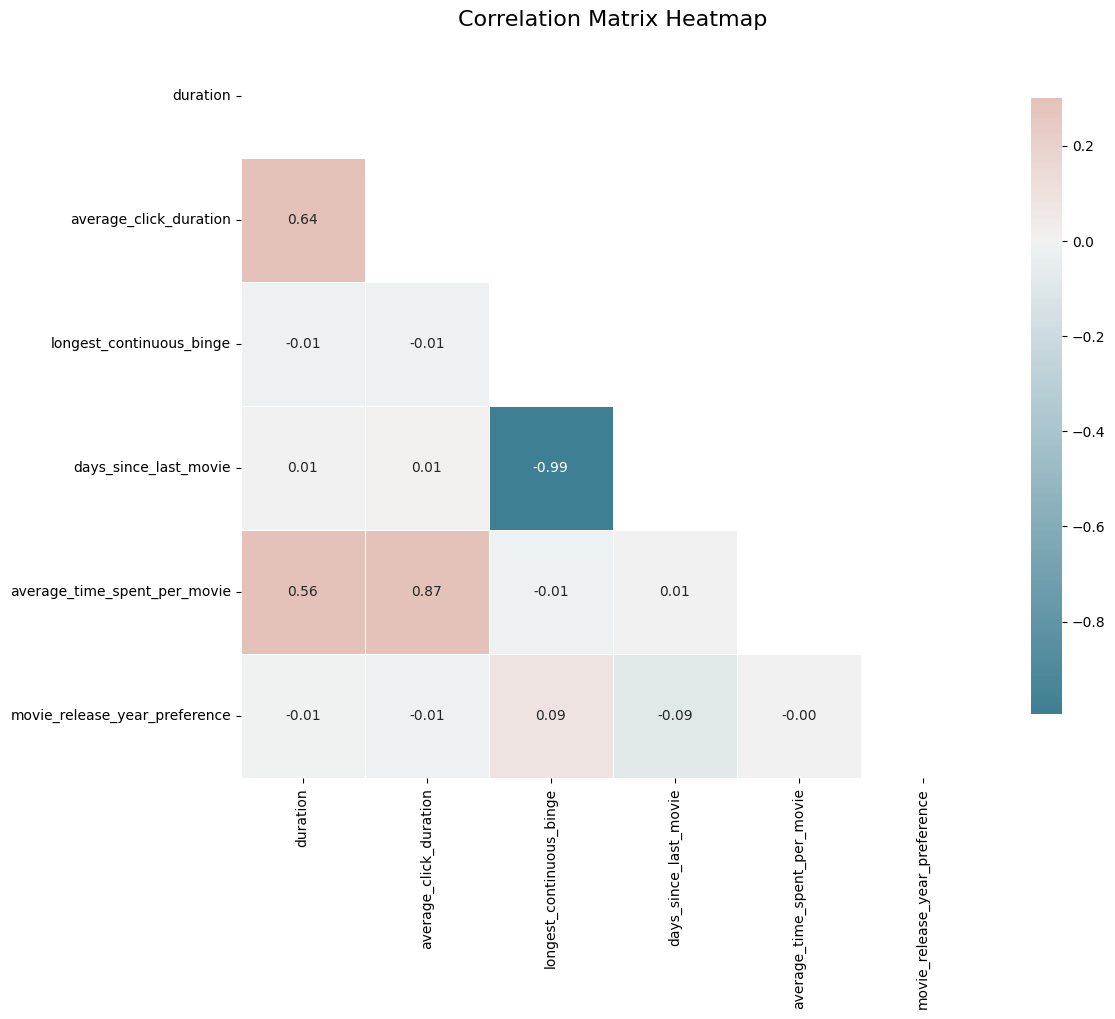

In [30]:

# Selecting numerical columns for correlation analysis
numerical_columns = ['duration', 'average_click_duration', 'longest_continuous_binge', 'days_since_last_movie', 'average_time_spent_per_movie', 'movie_release_year_preference']

# Creating a subset of the DataFrame with numerical columns
numerical_data = Netflix[numerical_columns]

# Create a correlation matrix
correlation_matrix = numerical_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", annot_kws={"size": 10},
            cbar_kws={"shrink": .8})

# Add a title
plt.title("Correlation Matrix Heatmap", fontsize=16)

# Show the plot
plt.show()

As we can see from the confusion matrix features like: "average_time_spent_per_movie" and "average_click_duration" are highly correlated. 
High correlation between features, known as multicollinearity, can lead to challenges in statistical modeling, including loss of interpretability, unstable coefficients, increased standard errors, and difficulty in identifying important features. I will drop one of these features to reduce the dimension. In addition, the correlation between "days_since_last_movie" and "longest_continues_binge" indicates an extremely strong negative linear relationship between these two features. In practical terms, it means that as one feature increases, the other decreases almost perfectly linearly. This level of correlation suggests high redundancy between the two features. I will drop one of these features to avoid multicollinearity. 

In [31]:
# Creating a filtered version of the Netflix dataset
Netflix_filtered = Netflix.copy()

In [32]:
# Drop the specified columns
columns_to_drop = ['longest_continuous_binge', 'average_time_spent_per_movie']
Netflix_filtered = Netflix.drop(columns=columns_to_drop)

In [33]:
Netflix_filtered.head()

Unnamed: 0            datetime  duration  \
0       58773 2017-01-01 01:15:09       0.0   
1       58774 2017-01-01 13:56:02       0.0   
2       58775 2017-01-01 15:17:47   10530.0   
3       58776 2017-01-01 16:04:13      49.0   
4       58777 2017-01-01 19:16:37       0.0   

                                title  \
0  Angus, Thongs and Perfect Snogging   
1        The Curse of Sleeping Beauty   
2                   London Has Fallen   
3                            Vendetta   
4     The SpongeBob SquarePants Movie   

                                              genres release_date    movie_id  \
0                             Comedy, Drama, Romance   2008-07-25  26bd5987e8   
1                 Fantasy, Horror, Mystery, Thriller   2016-06-02  f26ed2675e   
2                                   Action, Thriller   2016-03-04  f77e500e7a   
3                                      Action, Drama   2015-06-12  c74aec7673   
4  Animation, Action, Adventure, Comedy, Family, ...   2004-11-19  a80d6fc2aa   

      user_id  average_click_duration time_of_day  ...       date  \
0  1dea19f6fe                0.000000       Night  ... 2017-01-01   
1  544dcbc510             1553.750000   Afternoon  ... 2017-01-01   
2  7cbcc791bf             4218.666667   Afternoon  ... 2017-01-01   
3  ebf43c36b6             1883.533333   Afternoon  ... 2017-01-01   
4  a57c992287             3684.538462     Evening  ... 2017-01-01   

  average_time_spent_per_day  total_movies_watched  favorite_genre  \
0                   0.000000                     1          Comedy   
1               18645.000000                    12        Thriller   
2                9564.666667                     6        Thriller   
3                9610.000000                    15           Drama   
4               10814.615385                    26       Animation   

  average_click_duration_per_genre  preferred_time_of_watching  \
0                         0.000000                       Night   
1                      1553.750000                   Afternoon   
2                      4218.666667                       Night   
3                      1883.533333                   Afternoon   
4                      3684.538462                   Afternoon   

  days_since_last_movie  movie_diversity  weekday_vs_weekend_preference  \
0                  2558                1                        Weekend   
1                  2558                7                        Weekend   
2                  2555                4                        Weekend   
3                  2551                8                        Weekend   
4                  2525               21                        Weekday   

  movie_release_year_preference  
0                        2008.0  
1                        2008.0  
2                        2016.0  
3                        2016.0  
4                        2016.0  

[5 rows x 21 columns]

#### Categorical Features

In [34]:
# Display the data types of each column
data_types = Netflix.dtypes

# Filter columns with categorical data types
categorical_columns = data_types[data_types == 'object'].index.tolist()

# Print the list of categorical columns
print("Categorical Columns:")
print(categorical_columns)

Categorical Columns:
['title', 'genres', 'movie_id', 'user_id', 'favorite_genre', 'preferred_time_of_watching', 'weekday_vs_weekend_preference']


In [35]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# List of categorical features to encode
categorical_features = ['title', 'genres', 'movie_id','time_of_day', 'favorite_genre', 'preferred_time_of_watching', 'weekday_vs_weekend_preference']


Netflix_filtered[categorical_features] = Netflix_filtered[categorical_features].apply(label_encoder.fit_transform)

# Display the encoded DataFrame
Netflix_filtered.head()

Unnamed: 0            datetime  duration  title  genres release_date  \
0       58773 2017-01-01 01:15:09       0.0    543     734   2008-07-25   
1       58774 2017-01-01 13:56:02       0.0   6210    1120   2016-06-02   
2       58775 2017-01-01 15:17:47   10530.0   3680     303   2016-03-04   
3       58776 2017-01-01 16:04:13      49.0   7550     225   2015-06-12   
4       58777 2017-01-01 19:16:37       0.0   7020     432   2004-11-19   

   movie_id     user_id  average_click_duration  time_of_day  ...       date  \
0      1345  1dea19f6fe                0.000000            3  ... 2017-01-01   
1      7989  544dcbc510             1553.750000            0  ... 2017-01-01   
2      8166  7cbcc791bf             4218.666667            0  ... 2017-01-01   
3      6547  ebf43c36b6             1883.533333            0  ... 2017-01-01   
4      5546  a57c992287             3684.538462            1  ... 2017-01-01   

  average_time_spent_per_day  total_movies_watched  favorite_genre  \
0                   0.000000                     1              27   
1               18645.000000                    12              20   
2                9564.666667                     6              20   
3                9610.000000                    15               6   
4               10814.615385                    26              25   

   average_click_duration_per_genre  preferred_time_of_watching  \
0                          0.000000                           3   
1                       1553.750000                           0   
2                       4218.666667                           3   
3                       1883.533333                           0   
4                       3684.538462                           0   

   days_since_last_movie  movie_diversity  weekday_vs_weekend_preference  \
0                   2558                1                              1   
1                   2558                7                              1   
2                   2555                4                              1   
3                   2551                8                              1   
4                   2525               21                              0   

   movie_release_year_preference  
0                         2008.0  
1                         2008.0  
2                         2016.0  
3                         2016.0  
4                         2016.0  

[5 rows x 21 columns]

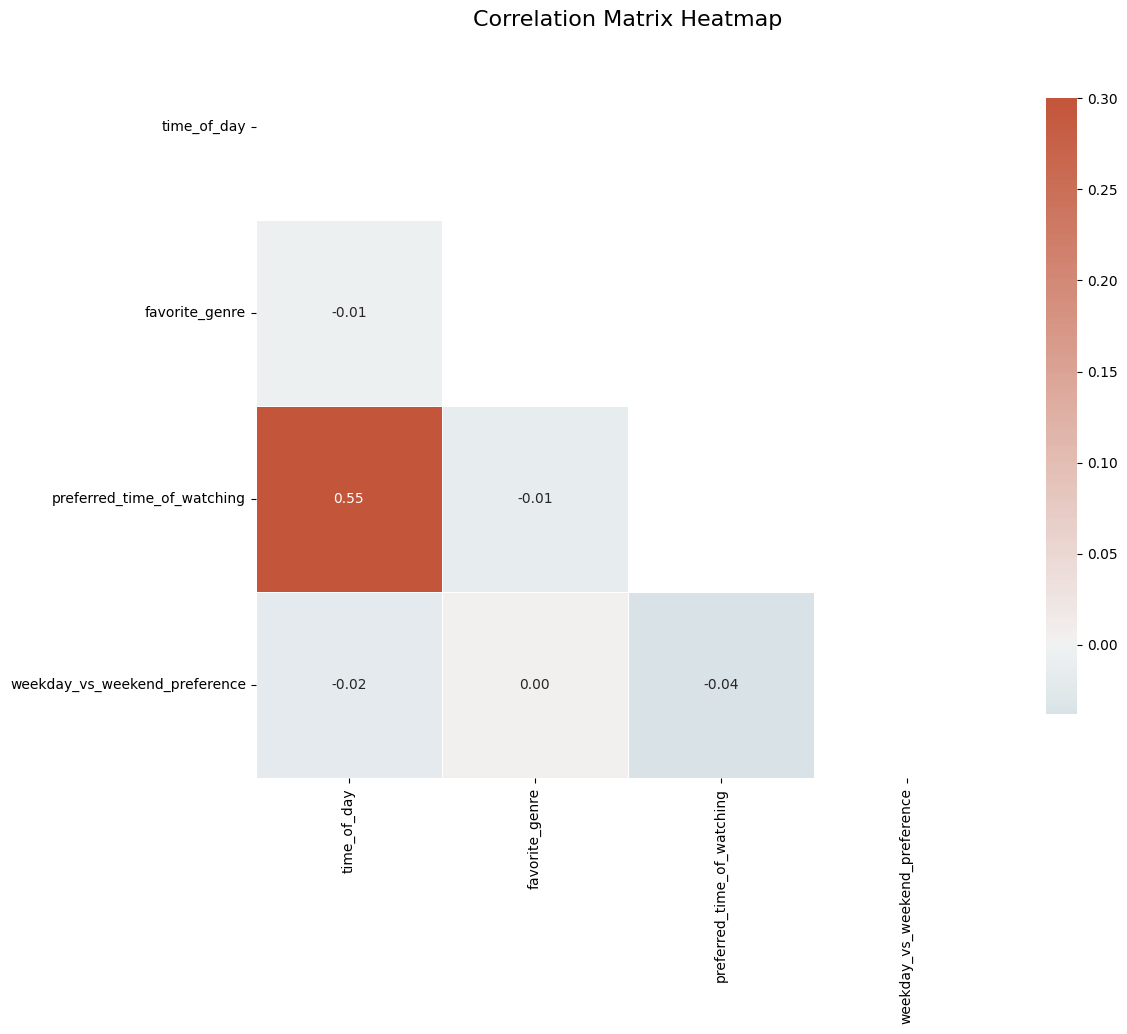

In [36]:
# Selecting numerical columns for correlation analysis
categorical_features = ['time_of_day', 'favorite_genre', 'preferred_time_of_watching', 'weekday_vs_weekend_preference']

# Creating a subset of the DataFrame with numerical columns
categorical_data = Netflix_filtered[categorical_features]

# Create a correlation matrix
correlation_matrix = categorical_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", annot_kws={"size": 10},
            cbar_kws={"shrink": .8})

# Add a title
plt.title("Correlation Matrix Heatmap", fontsize=16)

# Show the plot
plt.show()

In [37]:
Netflix_filtered[categorical_features]

time_of_day  favorite_genre  preferred_time_of_watching  \
0                 3              27                           3   
1                 0              20                           0   
2                 0              20                           3   
3                 0               6                           0   
4                 1              25                           0   
...             ...             ...                         ...   
671731            1              45                           1   
671732            1              25                           1   
671733            1              17                           1   
671734            1              12                           1   
671735            1              27                           1   

        weekday_vs_weekend_preference  
0                                   1  
1                                   1  
2                                   1  
3                                   1  
4                                   0  
...                               ...  
671731                              1  
671732                              0  
671733                              1  
671734                              1  
671735                              1  

[671736 rows x 4 columns]

As we can see from the correlation matrix, all categorical features are barely correlated, with the exception of "preferred_time_of_watched" and "time_of_day", the correlation between these features is 0.55, which is considered moderate, which is why I decided not to drop any of these features.

#### Principal Component Analysis

Principal Component Analysis (PCA) is a statistical technique widely employed for dimensionality reduction and feature extraction in data analysis. Its key strength lies in efficiently decreasing the number of variables within a dataset while striving to retain essential information. Here are some compelling advantages of utilizing PCA:

##### 1. Data Visualization Mastery:
PCA plays a pivotal role in simplifying data visualization tasks. By projecting high-dimensional data onto a lower-dimensional space (typically 2 or 3 dimensions), PCA facilitates the identification of patterns, clusters, or trends in a visually accessible manner.

##### 2. Effective Collinearity Management:
In scenarios where independent variables exhibit high correlation (multicollinearity), PCA proves to be an invaluable tool. By generating orthogonal principal components (uncorrelated components), PCA adeptly addresses collinearity concerns. This not only enhances the interpretability of the data but also mitigates potential issues arising from correlated predictors.

##### 3. Dimensionality Reduction:
PCA excels at condensing complex datasets by transforming them into a set of uncorrelated variables, known as principal components. This reduction in dimensionality aids in streamlining subsequent analyses, making them more computationally efficient.

##### 4. Retained Variability:
Despite the reduction in dimensionality, PCA strives to retain as much of the original variability in the data as possible. This ensures that critical information is preserved, allowing for insightful and accurate analyses.

##### 5. Feature Extraction:
PCA provides a mechanism for identifying the most influential features within a dataset. The principal components represent combinations of original features, offering a clearer understanding of the underlying structure and contributing factors.

##### 6. Robustness in Exploratory Data Analysis:
PCA is particularly effective in exploratory data analysis, where understanding the inherent patterns and relationships in the data is crucial. The transformed principal components simplify the interpretation of complex structures within the dataset.

##### Conclusion:
In summary, PCA is a versatile tool with far-reaching applications, making it a cornerstone in various data analysis endeavors. Its ability to enhance interpretability, manage collinearity, and facilitate insightful visualizations positions PCA as a go-to technique for extracting meaningful insights from diverse datasets.

In [38]:
features = ['user_id','average_click_duration', 'days_since_last_movie',
            'movie_release_year_preference','time_of_day', 'favorite_genre',
            'preferred_time_of_watching', 'weekday_vs_weekend_preference']
Netflix_reduced = Netflix_filtered[features]
# Now we need to drop all duplicates and keep one row for each user
Netflix_reduced = Netflix_reduced.drop_duplicates(subset='user_id', keep='first')

In [39]:
Netflix_reduced

user_id  average_click_duration  days_since_last_movie  \
0       1dea19f6fe                0.000000                   2558   
1       544dcbc510             1553.750000                   2558   
2       7cbcc791bf             4218.666667                   2555   
3       ebf43c36b6             1883.533333                   2551   
4       a57c992287             3684.538462                   2525   
...            ...                     ...                    ...   
671702  45414be0ec                0.000000                   1648   
671705  783ec67e84                0.000000                   1648   
671727  89c715f3a4               -1.000000                   1648   
671730  9207e1499b            42592.000000                   1648   
671731  57501964fd              851.000000                   1648   

        movie_release_year_preference  time_of_day  favorite_genre  \
0                              2008.0            3              27   
1                              2008.0            0              20   
2                              2016.0            0              20   
3                              2016.0            0               6   
4                              2016.0            1              25   
...                               ...          ...             ...   
671702                         2019.0            0              27   
671705                         2009.0            1              26   
671727                         2017.0            1              25   
671730                         2013.0            1              26   
671731                         2019.0            1              45   

        preferred_time_of_watching  weekday_vs_weekend_preference  
0                                3                              1  
1                                0                              1  
2                                3                              1  
3                                0                              1  
4                                0                              0  
...                            ...                            ...  
671702                           0                              1  
671705                           1                              1  
671727                           1                              1  
671730                           1                              1  
671731                           1                              1  

[161918 rows x 8 columns]

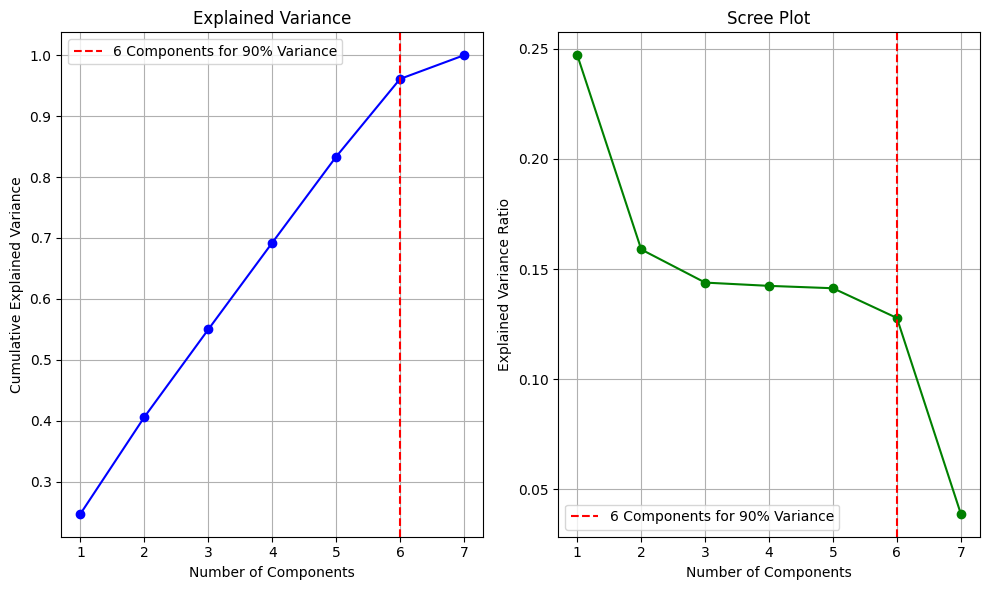

In [40]:

Netflix_pca = Netflix_reduced.loc[:, Netflix_reduced.columns != 'user_id']

# Standardize the data
scaler = StandardScaler()
Netflix_pca_standardized = scaler.fit_transform(Netflix_pca)

# Apply PCA
pca = PCA()
features_for_pca = pca.fit_transform(Netflix_pca_standardized)

# Calculate the cumulative explained variance
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components to keep for 90% variance explained
n_components = np.argmax(cumulative_variance_ratio >= 0.90) + 1

# Visualization
plt.figure(figsize=(10, 6))

# Explained Variance Plot
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance_ratio, marker='o', linestyle='-', color='b')
plt.title('Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=n_components, color='r', linestyle='--', label=f'{n_components} Components for 90% Variance')
plt.legend()
plt.grid(True)

# Scree Plot
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='-', color='g')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.axvline(x=n_components, color='r', linestyle='--', label=f'{n_components} Components for 90% Variance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Applying the PCA with the 6 compronents for achieving the 90% Variance

In [41]:
pca = PCA(n_components=n_components)
Netflix_filtered = pca.fit_transform(Netflix_pca)

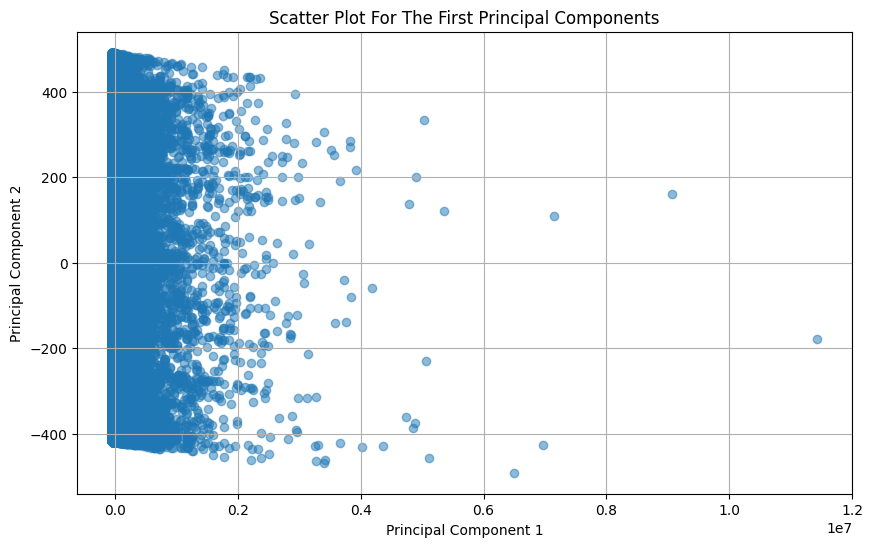

In [42]:

# Extract PCA components
pca1 = Netflix_filtered[:, 0]
pca2 = Netflix_filtered[:, 1]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca1, pca2, alpha=0.5)
plt.title('Scatter Plot For The First Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


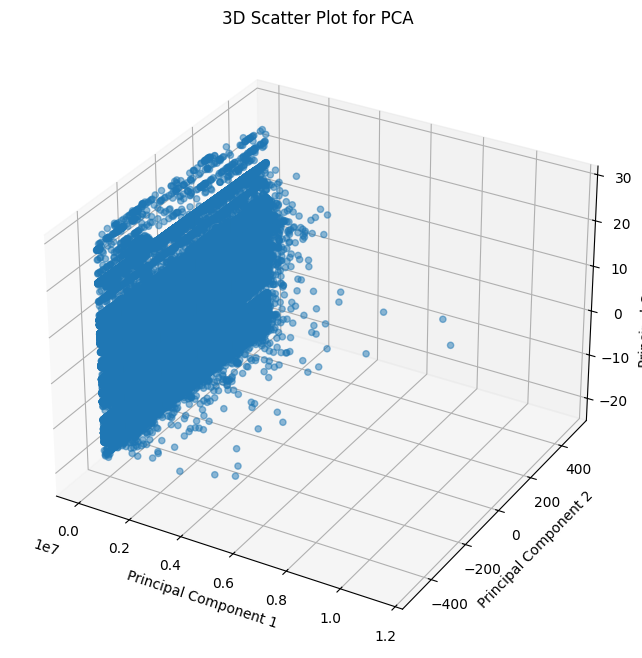

In [43]:
# Extract PCA components
pca1 = Netflix_filtered[:, 0]
pca2 = Netflix_filtered[:, 1]
pca3 = Netflix_filtered[:, 2]

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca1, pca2, pca3, alpha=0.5)

ax.set_title('3D Scatter Plot for PCA')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.grid(True)

plt.show()

In [44]:
Netflix_final=pd.DataFrame(Netflix_filtered)
Netflix_final

0           1          2         3         4         5
0      -43519.366316  491.716997   5.452223  1.901431  2.744175  0.275264
1      -41965.616316  491.667219  -1.541989  1.829969 -1.504097  0.111167
2      -39300.699719  488.582191  -1.464981 -6.155601  0.709274 -1.891110
3      -41635.833142  484.606071 -15.452614 -6.278032 -1.509445  0.110959
4      -39834.828603  458.604822   3.599038 -6.019500 -0.796460  0.630982
...              ...         ...        ...       ...       ...       ...
161913 -43519.386917 -418.310915   7.414495 -6.266543 -1.450638  0.092732
161914 -43519.386916 -418.281944   6.319699  3.725760 -0.054070  0.156307
161915 -43520.386916 -418.308783   5.394187 -4.283144 -0.043118  0.150736
161916   -927.386927 -419.258512   6.359467 -0.275505 -0.049183  0.153419
161917 -42668.386917 -418.292930  25.411923 -6.097053 -0.014698  0.140905

[161918 rows x 6 columns]

In [45]:
#Lets make the user_id primary key for the final version of our Netflix Dataset
Netflix_final.index = Netflix_reduced['user_id']
Netflix_final

0           1          2         3         4         5
user_id                                                                      
1dea19f6fe -43519.366316  491.716997   5.452223  1.901431  2.744175  0.275264
544dcbc510 -41965.616316  491.667219  -1.541989  1.829969 -1.504097  0.111167
7cbcc791bf -39300.699719  488.582191  -1.464981 -6.155601  0.709274 -1.891110
ebf43c36b6 -41635.833142  484.606071 -15.452614 -6.278032 -1.509445  0.110959
a57c992287 -39834.828603  458.604822   3.599038 -6.019500 -0.796460  0.630982
...                  ...         ...        ...       ...       ...       ...
45414be0ec -43519.386917 -418.310915   7.414495 -6.266543 -1.450638  0.092732
783ec67e84 -43519.386916 -418.281944   6.319699  3.725760 -0.054070  0.156307
89c715f3a4 -43520.386916 -418.308783   5.394187 -4.283144 -0.043118  0.150736
9207e1499b   -927.386927 -419.258512   6.359467 -0.275505 -0.049183  0.153419
57501964fd -42668.386917 -418.292930  25.411923 -6.097053 -0.014698  0.140905

[161918 rows x 6 columns]

In [46]:
# Now lets save it as a csv file
Netflix_final.to_csv('Netflix_final.csv')

### 2.3 Clustering

In [47]:
def assign_centroid(centroids, p):
    """
    Assign a data point to the closest centroid.

    Parameters:
    - centroids: Array of current centroid positions
    - p: Data point to be assigned

    Returns:
    Index of the closest centroid for the given data point.
    """
    # Compute the distances from all the centroids using NumPy operations
    distances = np.linalg.norm(centroids - p, axis=1)
    # Choose the closest centroid
    closest_centroid = np.argmin(distances)
    return closest_centroid

def map_(data, centroids):
    """
    Map step of the k-means algorithm.

    Parameters:
    - data: Dataset
    - centroids: Current centroid positions

    Returns:
    List of tuples, where each tuple contains the index of the assigned centroid and the data point.
    """
    # Use list comprehension for concise code
    cluster_assignments = [(assign_centroid(centroids, point), point) for point in data]
    return cluster_assignments

def reduce_(cluster_assignments, k):
    """
    Reduce step of the k-means algorithm.

    Parameters:
    - cluster_assignments: List of tuples, each containing the index of the assigned centroid and the data point
    - k: Number of clusters

    Returns:
    List of new centroid positions.
    """
    cluster_assignments = np.array(cluster_assignments, dtype=object)
    # For each cluster, take the mean of the points and set these as new centroids
    new_centroids = [np.mean(cluster_assignments[cluster_assignments[:, 0] == i][:, 1], axis=0) for i in range(k)]
    return new_centroids

def plot_clusters(data, centroids, cluster_assignments, k, i):
    """
    Plot clustered data and centroids using PCA for visualization.

    Parameters:
    - data: Dataset
    - centroids: Current centroid positions
    - cluster_assignments: List of tuples, each containing the index of the assigned centroid and the data point
    - k: Number of clusters
    - i: Iteration number
    """
    # In order to visualize the clustering process, use PCA once again to make a 2-dimensional plot
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids)
    cluster_ids, clustered_data = zip(*cluster_assignments)
    
    # Plot the clustered data
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_ids, cmap='viridis', alpha=0.7)
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=100, c='red')
    plt.title(f'Iteration (i={i})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

# K-means algorithm
def kmeans_from_scratch_with_plot_mapreduce(data, k, max_iterations=100):
    """
    K-means clustering algorithm with MapReduce implementation and visualization.

    Parameters:
    - data: Dataset
    - k: Number of clusters
    - max_iterations: Maximum number of iterations

    Returns:
    Final centroid positions.
    """
    # Step 1: Initialize centroids randomly
    centroids = data[np.random.choice(len(data), k, replace=False)]
    
    # Iterate for a maximum of max_iterations
    for i in range(max_iterations):
        # Step 2: Get labels for each data point (Map)
        cluster_assignments = map_(data, centroids)
        
        # Step 3: Create new centroids (Reduce)
        new_centroids = reduce_(cluster_assignments, k)
        
        # Step 4: Plot the centroids
        plot_clusters(data, centroids, cluster_assignments, k, i)
        
        # Step 5: Repeat 3-5 until the centroids stop changing
        if np.all(np.array(new_centroids) == np.array(centroids)):
            break

        # Update centroids for the next iteration
        centroids = new_centroids

    return centroids

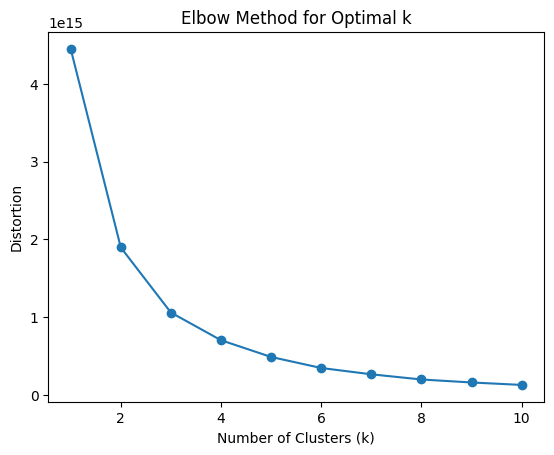

In [48]:
def elbow_method(data, max_k=10):
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    return distortions

def plot_elbow(distortions, max_k=10):
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Distortion')
    plt.show()

# Use with your dataset
data = Netflix_filtered
max_k = 10
distortions = elbow_method(data, max_k)
plot_elbow(distortions, max_k)

As we can see from the visualization of Elbow Method, this algorithms suggests k=4 which mean that our data exhibits distinct patterns that can be effectively captured by partitioning it into four clusters. 

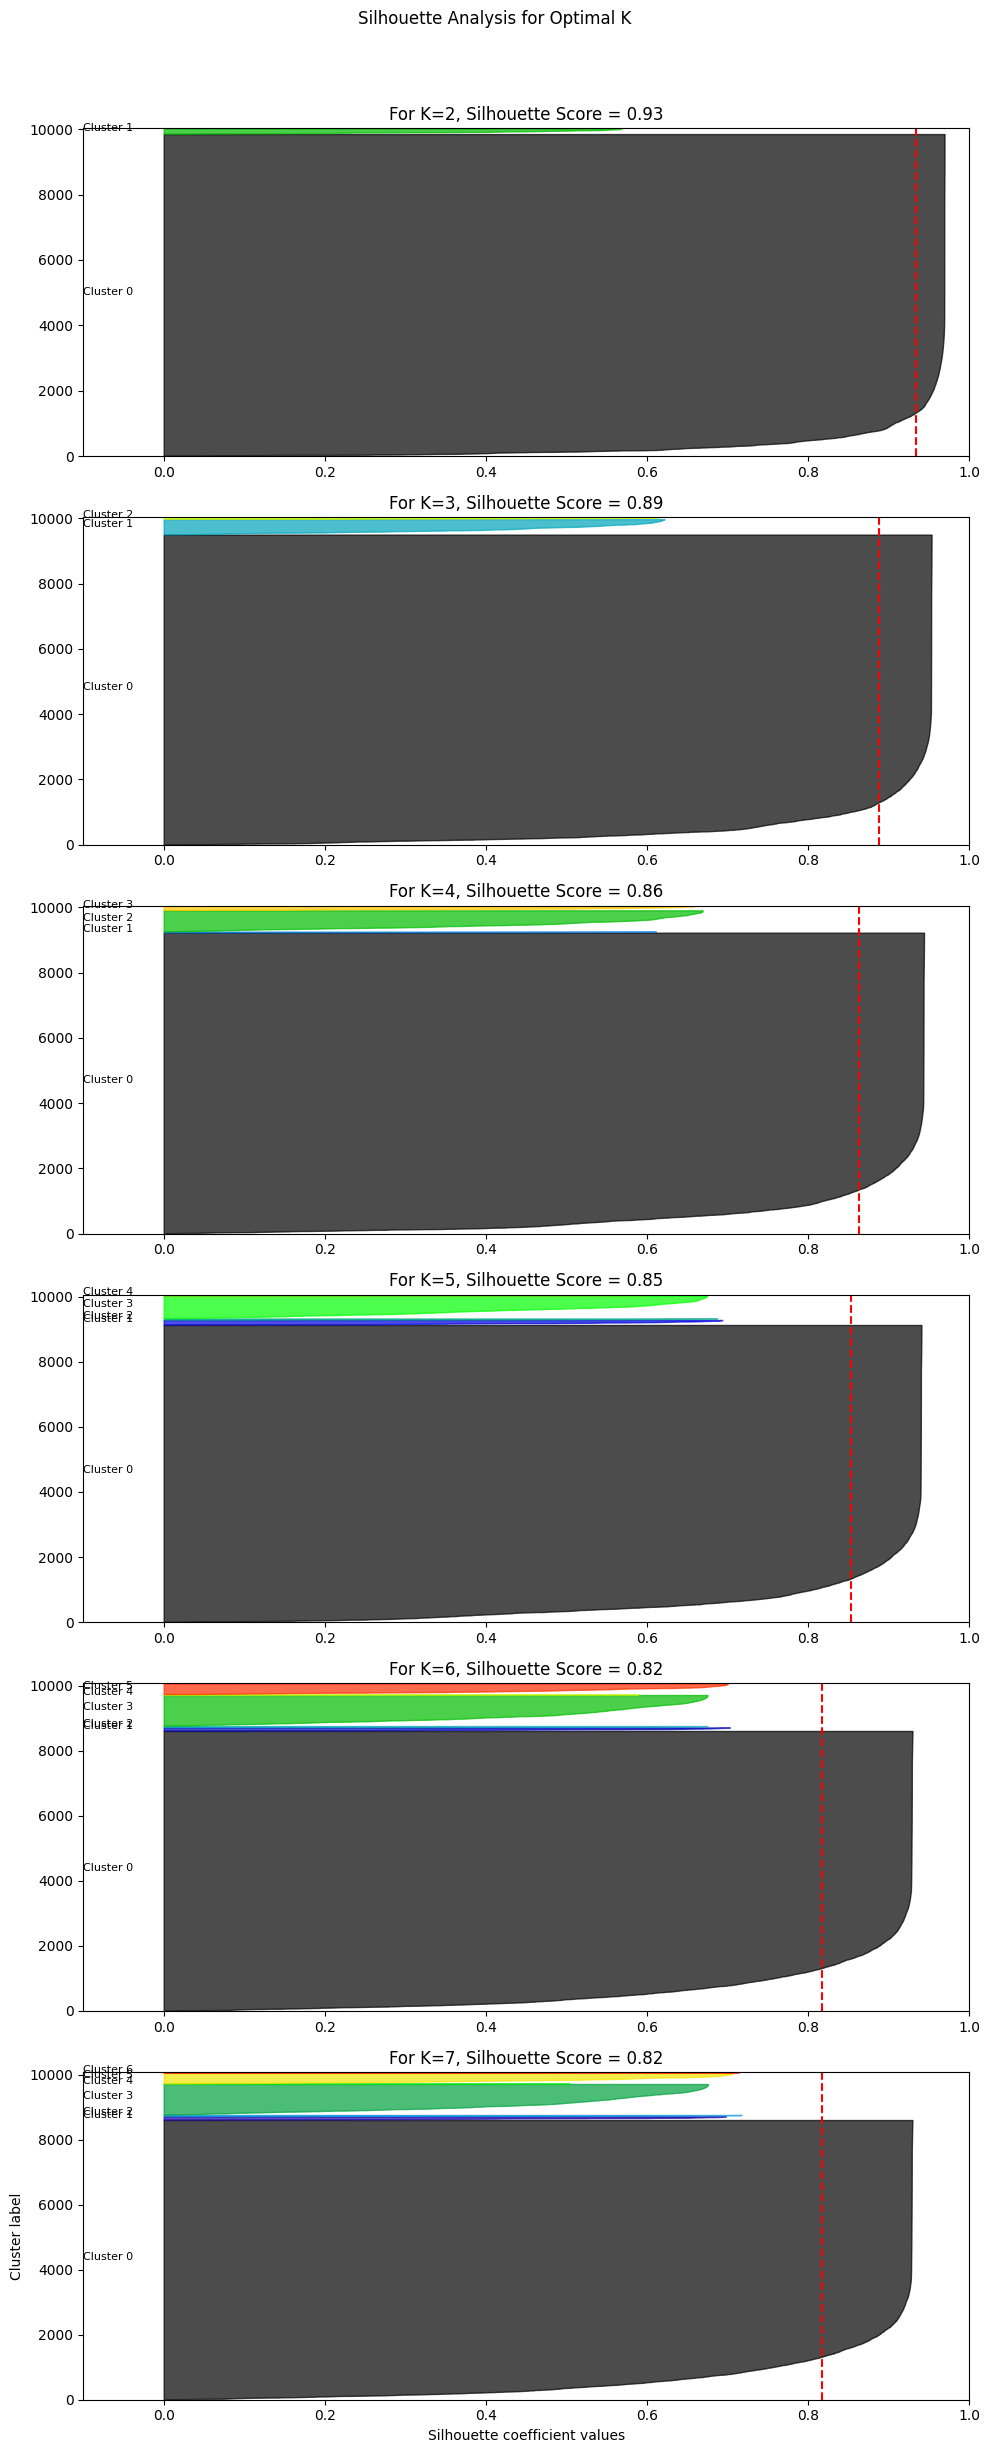

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs

# Sample 10,000 items from the dataset
data_sample = Netflix_final.sample(10000, random_state=42)

# Define a range of clusters to evaluate
clusters = [2, 3, 4, 5, 6, 7]

# Lists to store silhouette scores for each cluster and individual silhouette scores
silhouette_avg = []
silhouette_samples_values = []

# Iterate over different cluster values
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, random_state=42).fit(data_sample)
    cluster_labels = kmeans.labels_
    
    # Compute silhouette score
    silhouette_avg.append(silhouette_score(data_sample, cluster_labels))
    
    # Compute individual silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_sample, cluster_labels)
    silhouette_samples_values.append(sample_silhouette_values)

# Plotting the results
fig, ax1 = plt.subplots(len(clusters), 1, figsize=(10, len(clusters) * 4))
fig.suptitle('Silhouette Analysis for Optimal K', y=1.02)

for i, cluster in enumerate(clusters):
    y_lower = 10
    sample_silhouette_values = silhouette_samples_values[i]
    cluster_labels = KMeans(n_clusters=cluster, random_state=42).fit_predict(data_sample)
    
    for j in range(cluster):
        cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        cluster_silhouette_values.sort()

        size_cluster_j = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = plt.cm.nipy_spectral(float(j) / cluster)
        ax1[i].fill_betweenx(np.arange(y_lower, y_upper),
                              0, cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

        # Label at the middle of the silhouette plot
        ax1[i].text(-0.1, y_lower + 0.5 * size_cluster_j, f'Cluster {j}', color="black", fontsize=8)
        y_lower = y_upper + 10  

    ax1[i].set_xlim([-0.1, 1])
    ax1[i].set_ylim([0, len(data_sample) + (cluster + 1) * 10])
    ax1[i].set_title(f"For K={cluster}, Silhouette Score = {silhouette_avg[i]:.2f}")
    ax1[i].axvline(x=silhouette_avg[i], color="red", linestyle="--")

ax1[-1].set_xlabel('Silhouette coefficient values')
ax1[-1].set_ylabel('Cluster label')

plt.tight_layout()
plt.show()

Based on the silhouette scores it seems that the highest silhouette score is achieved when the number of clusters (k) is set to 2. The silhouette scores decrease as you increase the number of clusters:

- k2 = 0.93 (highest)
- k3 = 0.89
- k4 = 0.86
- k5 = 0.85
- k6 = 0.82
- k7 = 0.82

The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). A higher silhouette score indicates better-defined clusters with more separation between them.

In our case, the higher silhouette score for k=2 suggests that a partition into two clusters is more appropriate for our data compared to other values of k. This indicates that our data points are well-separated into two distinct groups.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


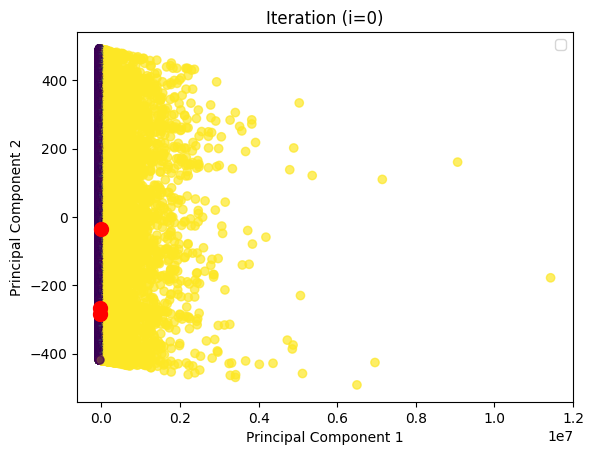

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


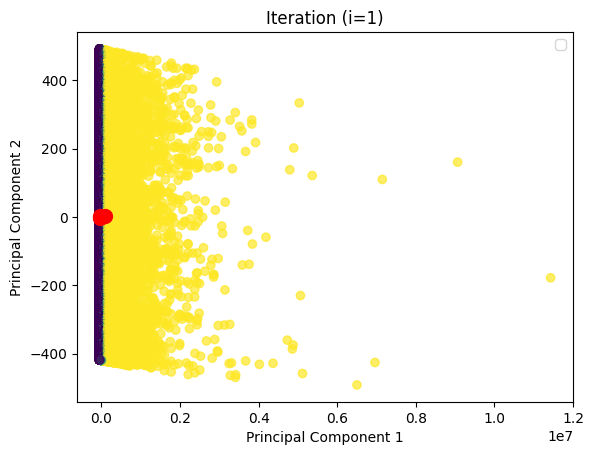

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


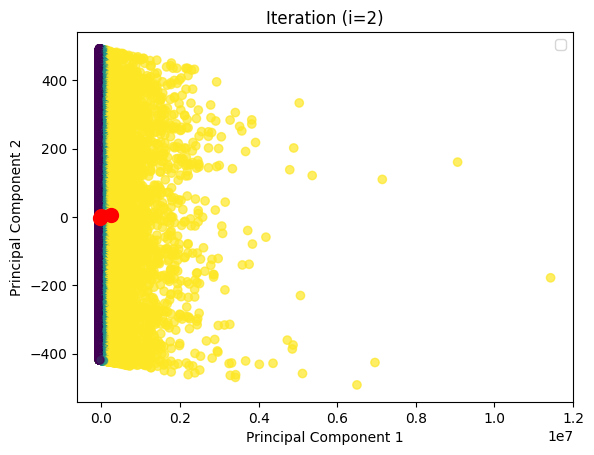

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


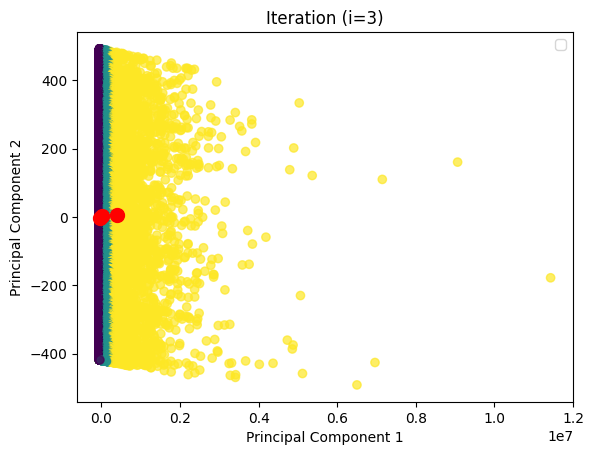

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


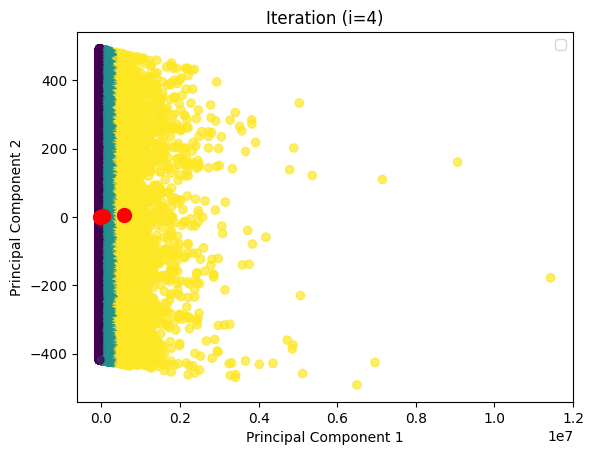

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


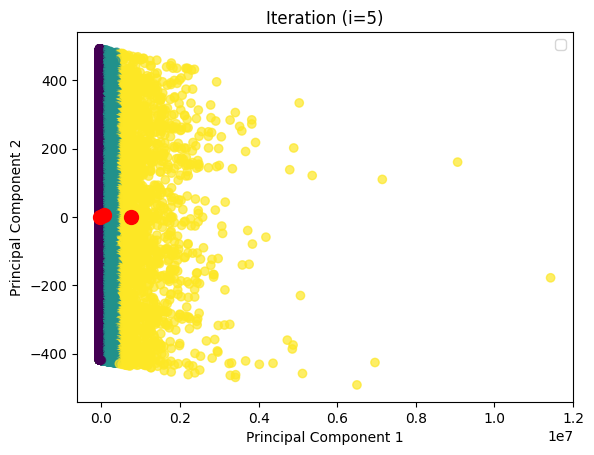

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


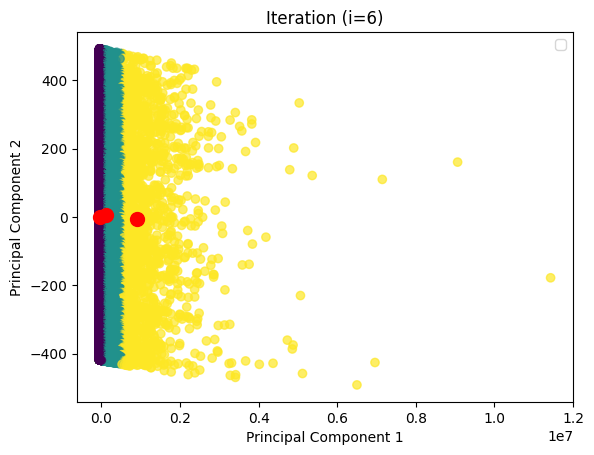

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


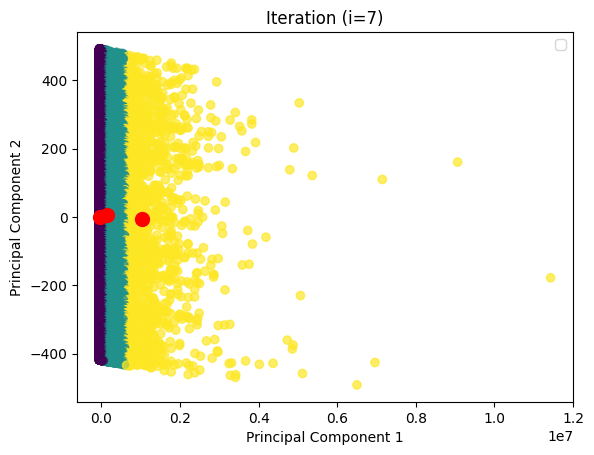

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


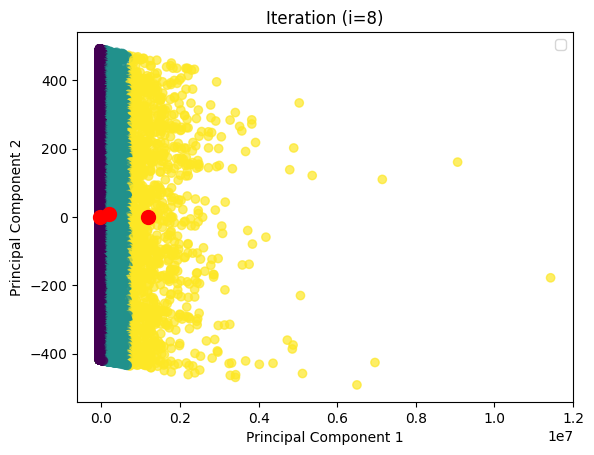

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


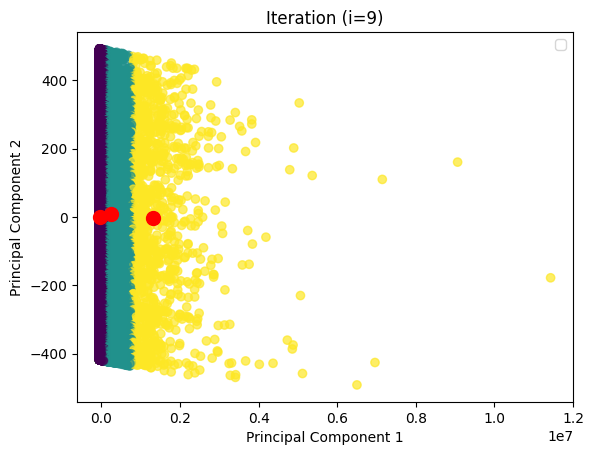

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


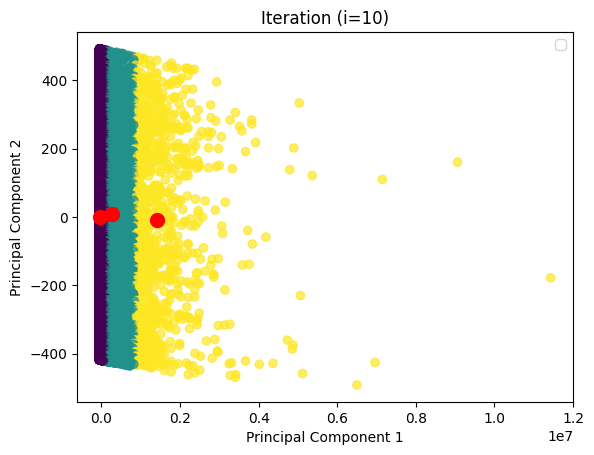

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


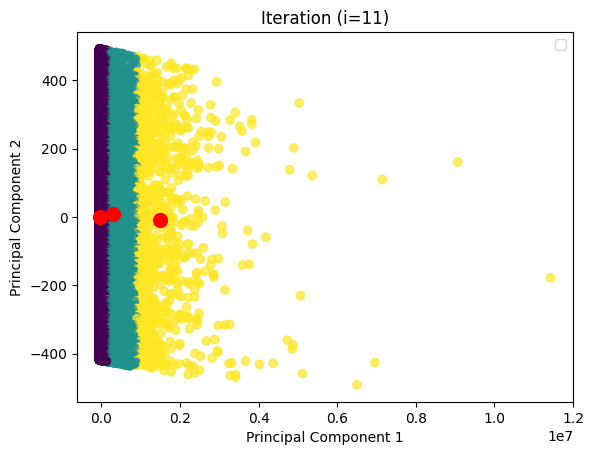

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


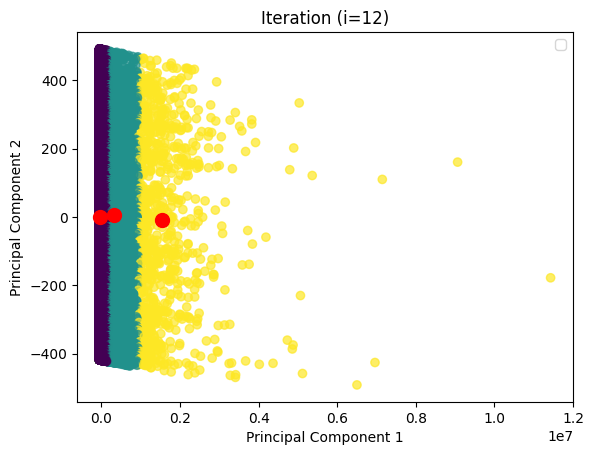

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


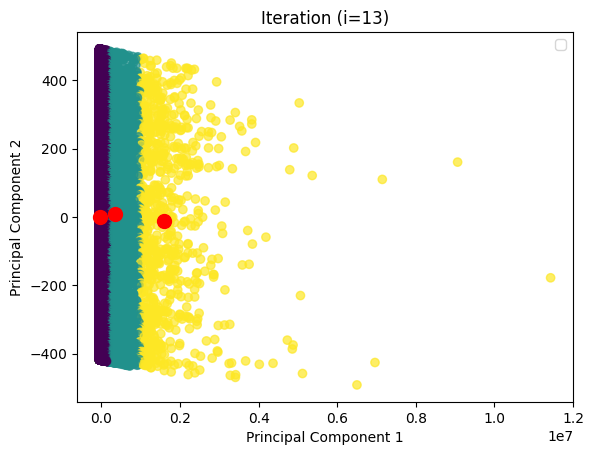

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


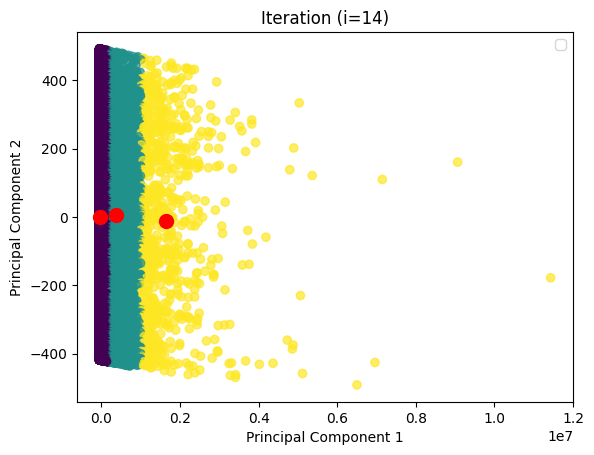

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


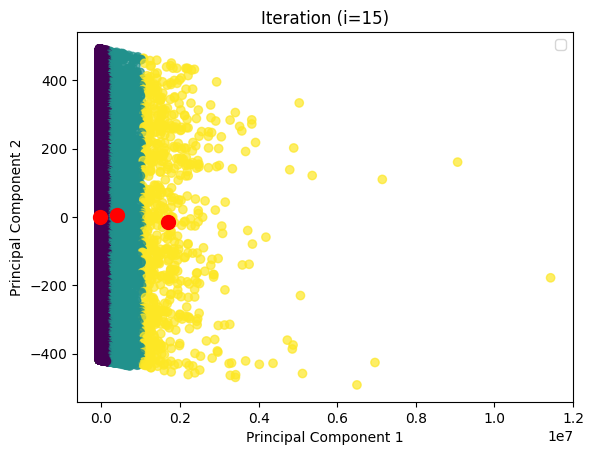

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


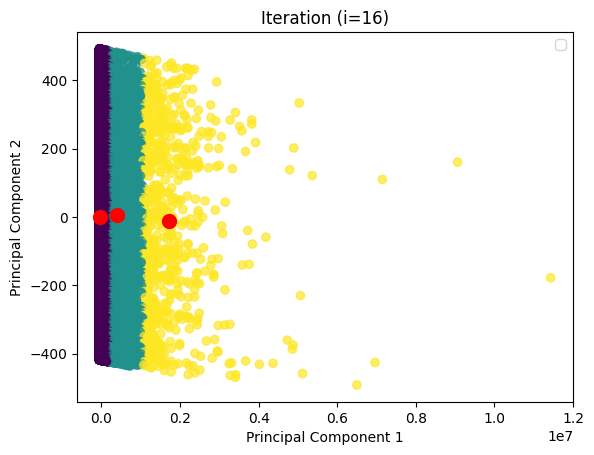

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


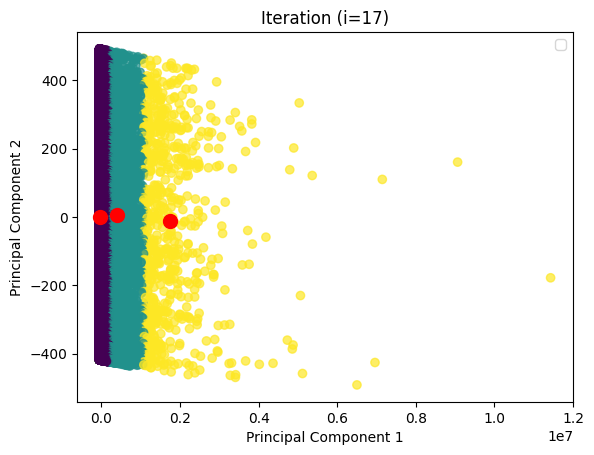

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


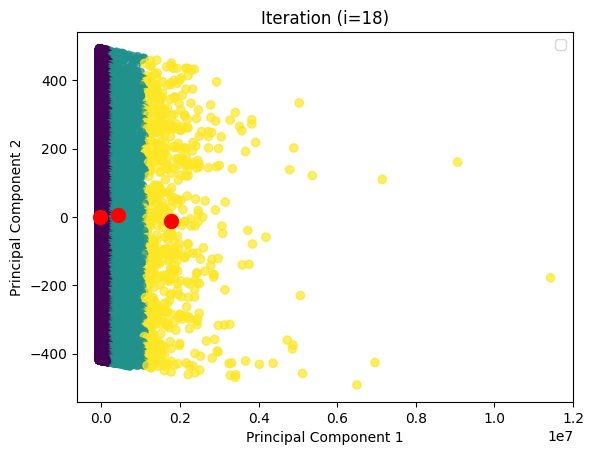

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


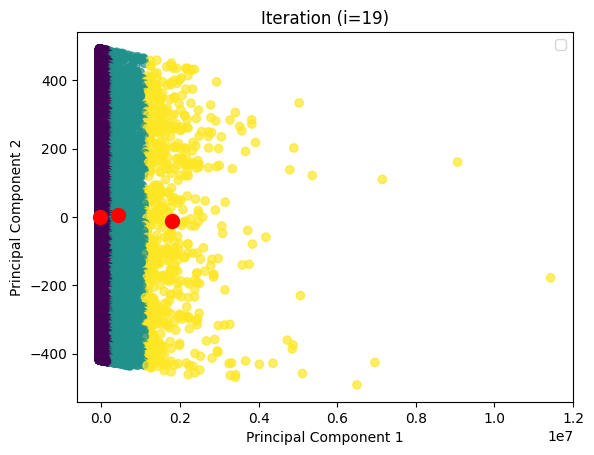

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


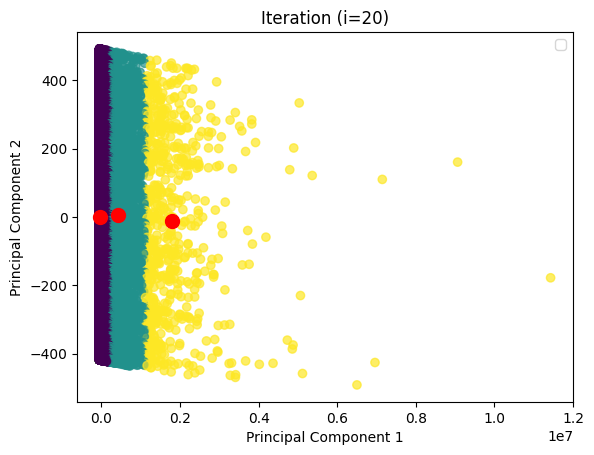

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


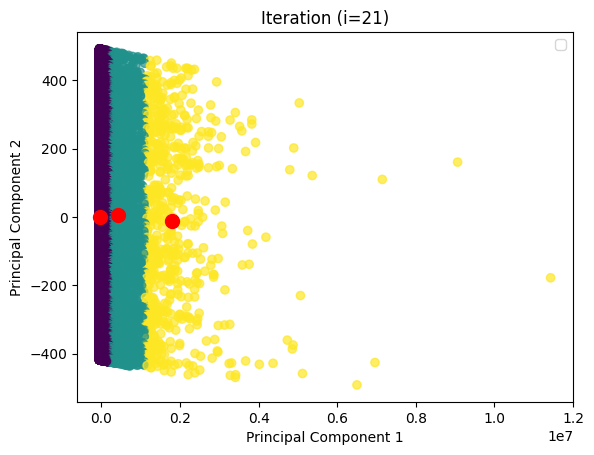

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


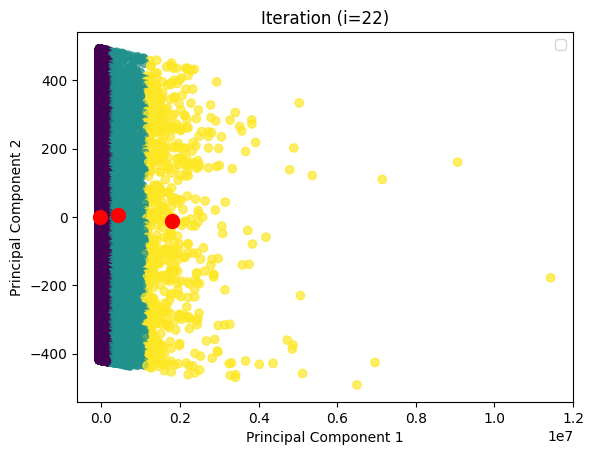

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


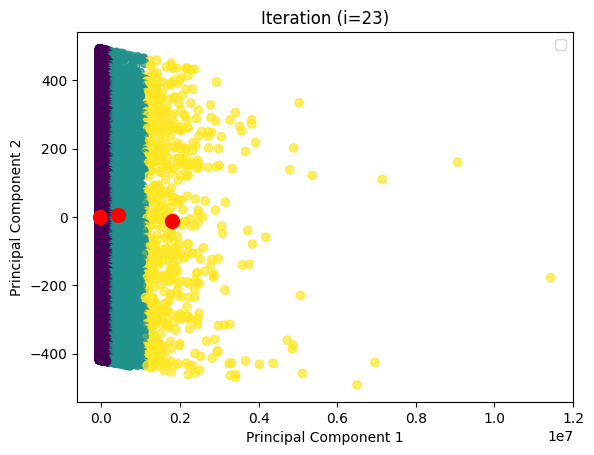

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


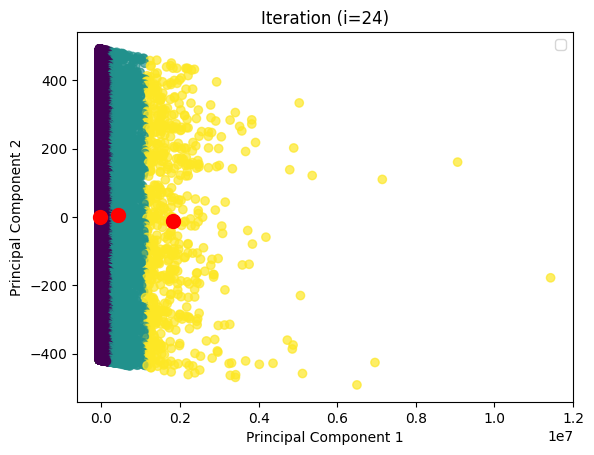

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


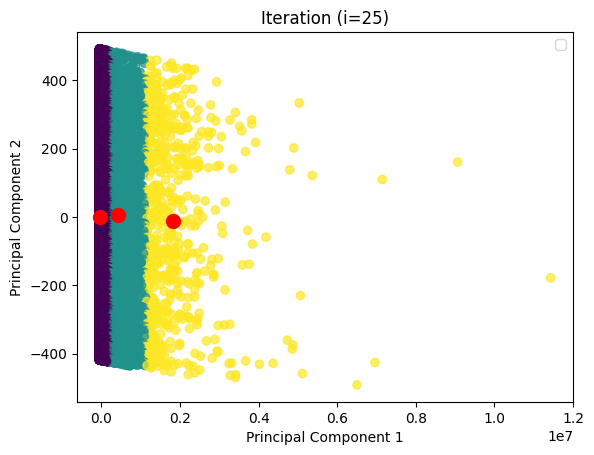

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


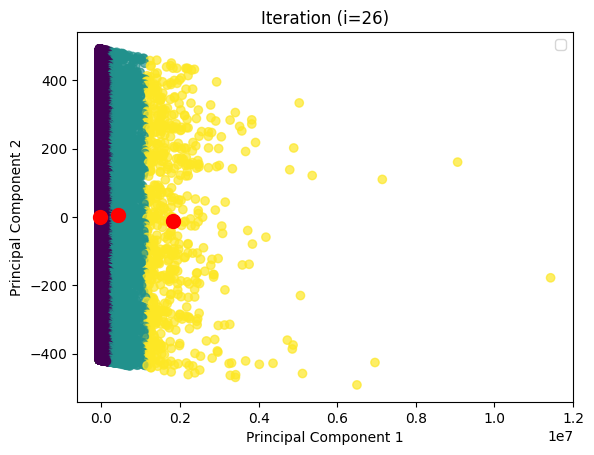

In [50]:
optimal_k=3
final_centroids = kmeans_from_scratch_with_plot_mapreduce(Netflix_filtered, optimal_k)

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_centroids_kmeans_pp(data, k):
    """
    Initialize centroids using the K-means++ method.

    Parameters:
    - data: Input data points.
    - k: Number of clusters.

    Returns:
    - centroids: Initial centroids.
    """
    centroids = [data[np.random.choice(data.shape[0])]]

    for _ in range(1, k):
        distances = np.array([min(np.linalg.norm(point - np.array(centroid)) for centroid in centroids) for point in data])
        probabilities = distances**2 / np.sum(distances**2)
        new_centroid = data[np.random.choice(data.shape[0], p=probabilities)]
        centroids.append(new_centroid)

    return np.array(centroids)

def map(data, centroids):
    """
    Assign each data point to the nearest centroid.

    Parameters:
    - data: Input data points.
    - centroids: Current centroids.

    Returns:
    - cluster_assignments: Array of cluster assignments for each data point.
    """
    cluster_assignments = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)
    return cluster_assignments

def reduce(data, cluster_assignments, k):
    """
    Compute new centroids based on the assigned clusters.

    Parameters:
    - data: Input data points.
    - cluster_assignments: Array of cluster assignments for each data point.
    - k: Number of clusters.

    Returns:
    - new_centroids: Updated centroids.
    """
    new_centroids = np.array([data[cluster_assignments == i].mean(axis=0) for i in range(k)])
    return new_centroids

def plot_clusters(data, centroids, cluster_assignments, k, iteration):
    """
    Plot the clusters and centroids.

    Parameters:
    - data: Input data points.
    - centroids: Current centroids.
    - cluster_assignments: Array of cluster assignments for each data point.
    - k: Number of clusters.
    - iteration: Iteration number.
    """
    plt.scatter(data[:, 0], data[:, 1], c=cluster_assignments, cmap='viridis', alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', label='Centroids')
    plt.title(f'K-means++ Clustering - Iteration {iteration}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

def kmeans_pp_with_plot(data, k, max_iterations=100):
    """
    K-means++ algorithm with map-reduce steps and plotting.

    Parameters:
    - data: Input data points.
    - k: Number of clusters.
    - max_iterations: Maximum number of iterations.

    Returns:
    - final_centroids: Final centroids after convergence.
    """
    # Step 1: Initialize centroids with the K-means++ method
    centroids = initialize_centroids_kmeans_pp(data, k)

    for i in range(max_iterations):
        # Step 2: Get labels for each data point (Map)
        cluster_assignments = map(data, centroids)

        # Step 3: Create new centroids (Reduce)
        new_centroids = reduce(data, cluster_assignments, k)

        # Step 4: Plot the centroids
        plot_clusters(data, centroids, cluster_assignments, k, i)

        # Step 5: Repeat until convergence
        if np.allclose(new_centroids, centroids):
            break

        # Update centroids for the next iteration
        centroids = new_centroids

    return centroids

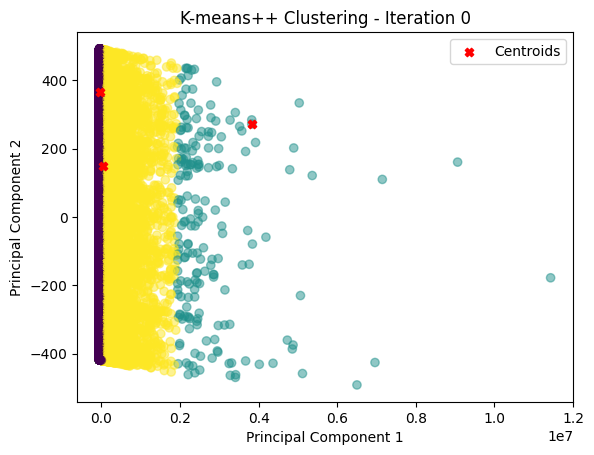

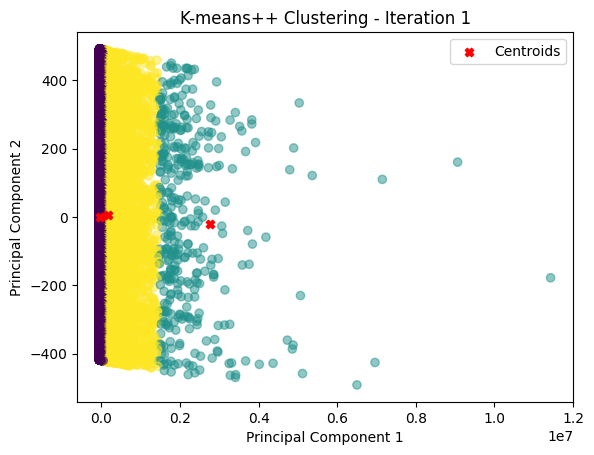

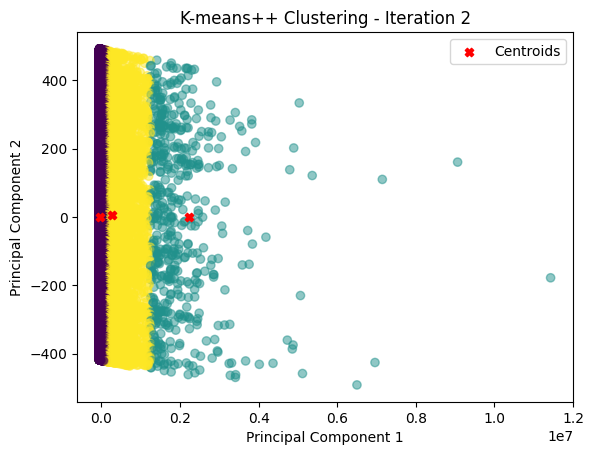

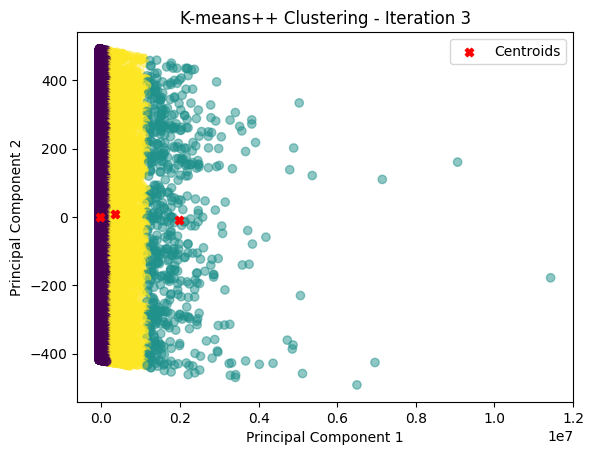

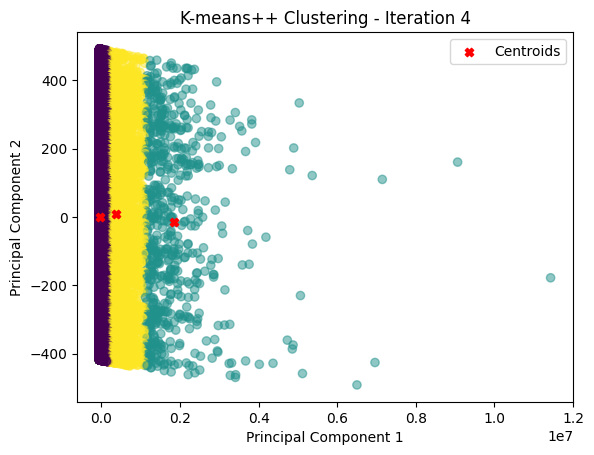

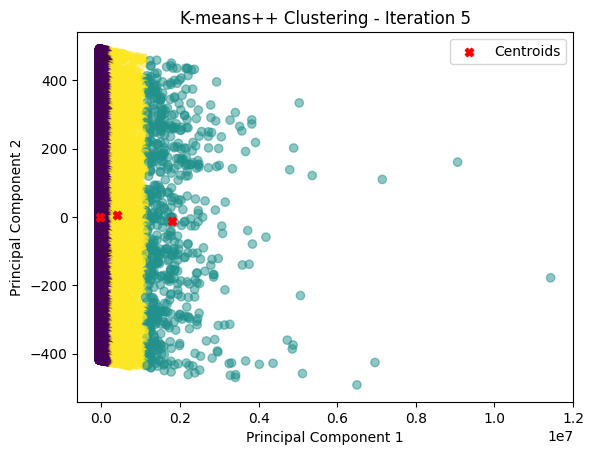

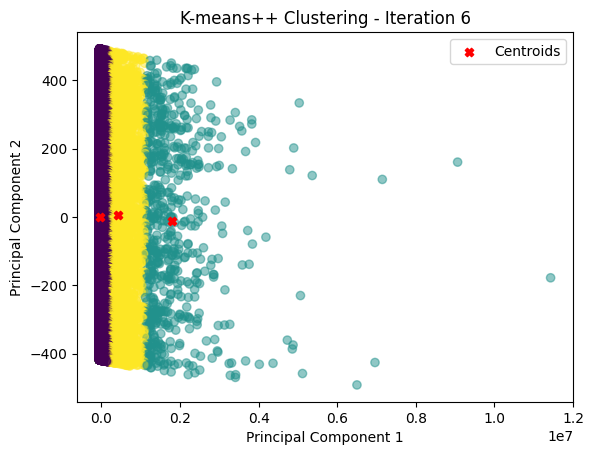

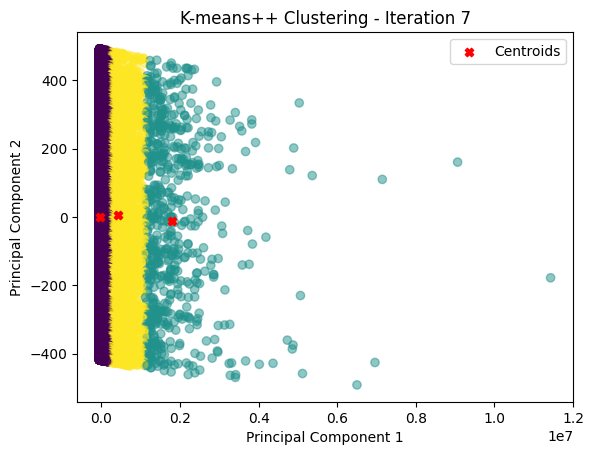

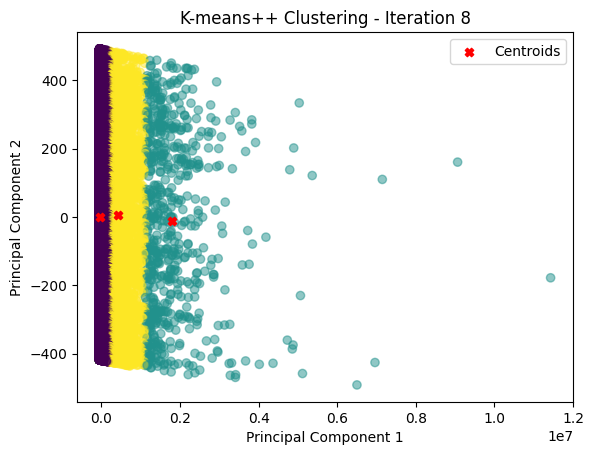

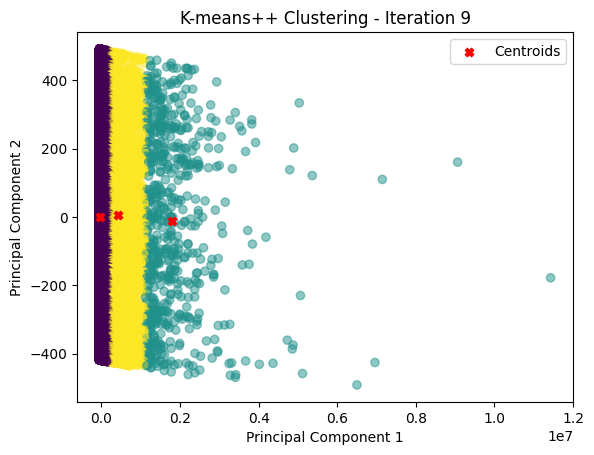

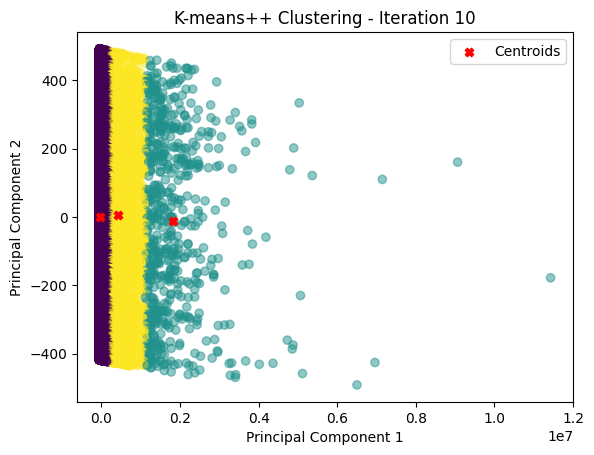

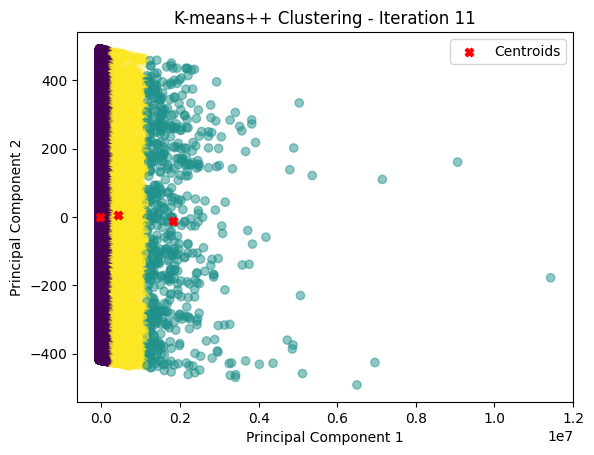

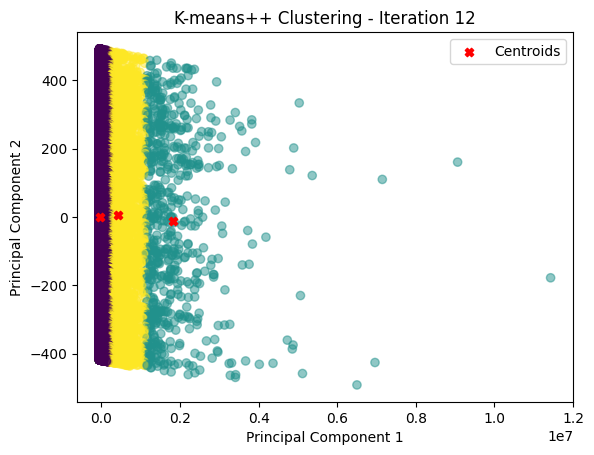

In [52]:
final_centroids = kmeans_pp_with_plot(Netflix_filtered, optimal_k)

There are various clustering algorithms available, and the choice often depends on the nature of your data and the desired properties of the clusters. One popular alternative to K-means is the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm.

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

**Explanation:**
- DBSCAN is a density-based clustering algorithm that doesn't require specifying the number of clusters in advance.
- It defines clusters as continuous regions of high density separated by areas of lower density.
- It is robust to outliers and can discover clusters of arbitrary shapes.

### Comparison and Interpretation:

**Differences:**
- DBSCAN does not require specifying the number of clusters (`k`) in advance, and it can discover clusters of arbitrary shapes.
- DBSCAN is sensitive to the `eps` (maximum distance between two samples for one to be considered as in the neighborhood of the other) and `min_samples` parameters.

**Results:**
- K-means creates spherical clusters based on centroids.
- DBSCAN identifies clusters based on the density of data points.

**Recommendation:**
- If the data has well-defined, spherical clusters and you have a clear idea of the number of clusters, K-means might be a good choice.
- If the data has irregularly shaped clusters, varying densities, or if you don't know the number of clusters beforehand, DBSCAN could be more suitable.

**Opinion:**
- The best algorithm depends on the characteristics of your data and your specific goals. K-means is simple and efficient, but DBSCAN might perform better in situations with complex cluster shapes or varying cluster densities.

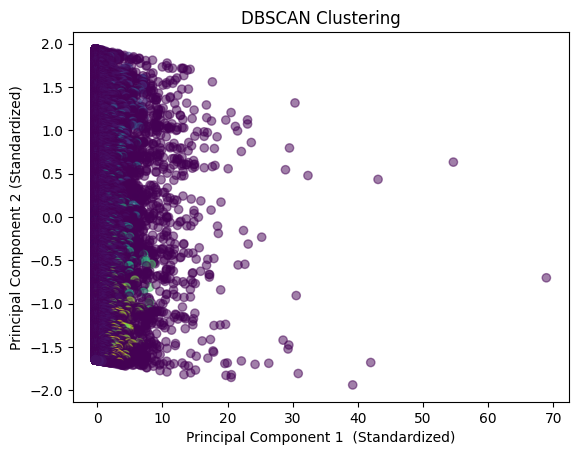

In [53]:

# Standardize the data before applying DBSCAN
scaler = StandardScaler()
data_scaled = scaler.fit_transform(Netflix_filtered)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_scaled)

# Plot DBSCAN results
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.5)
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1  (Standardized)')
plt.ylabel('Principal Component 2 (Standardized)')
plt.show()

### 4. Command Line Question (CLQ)

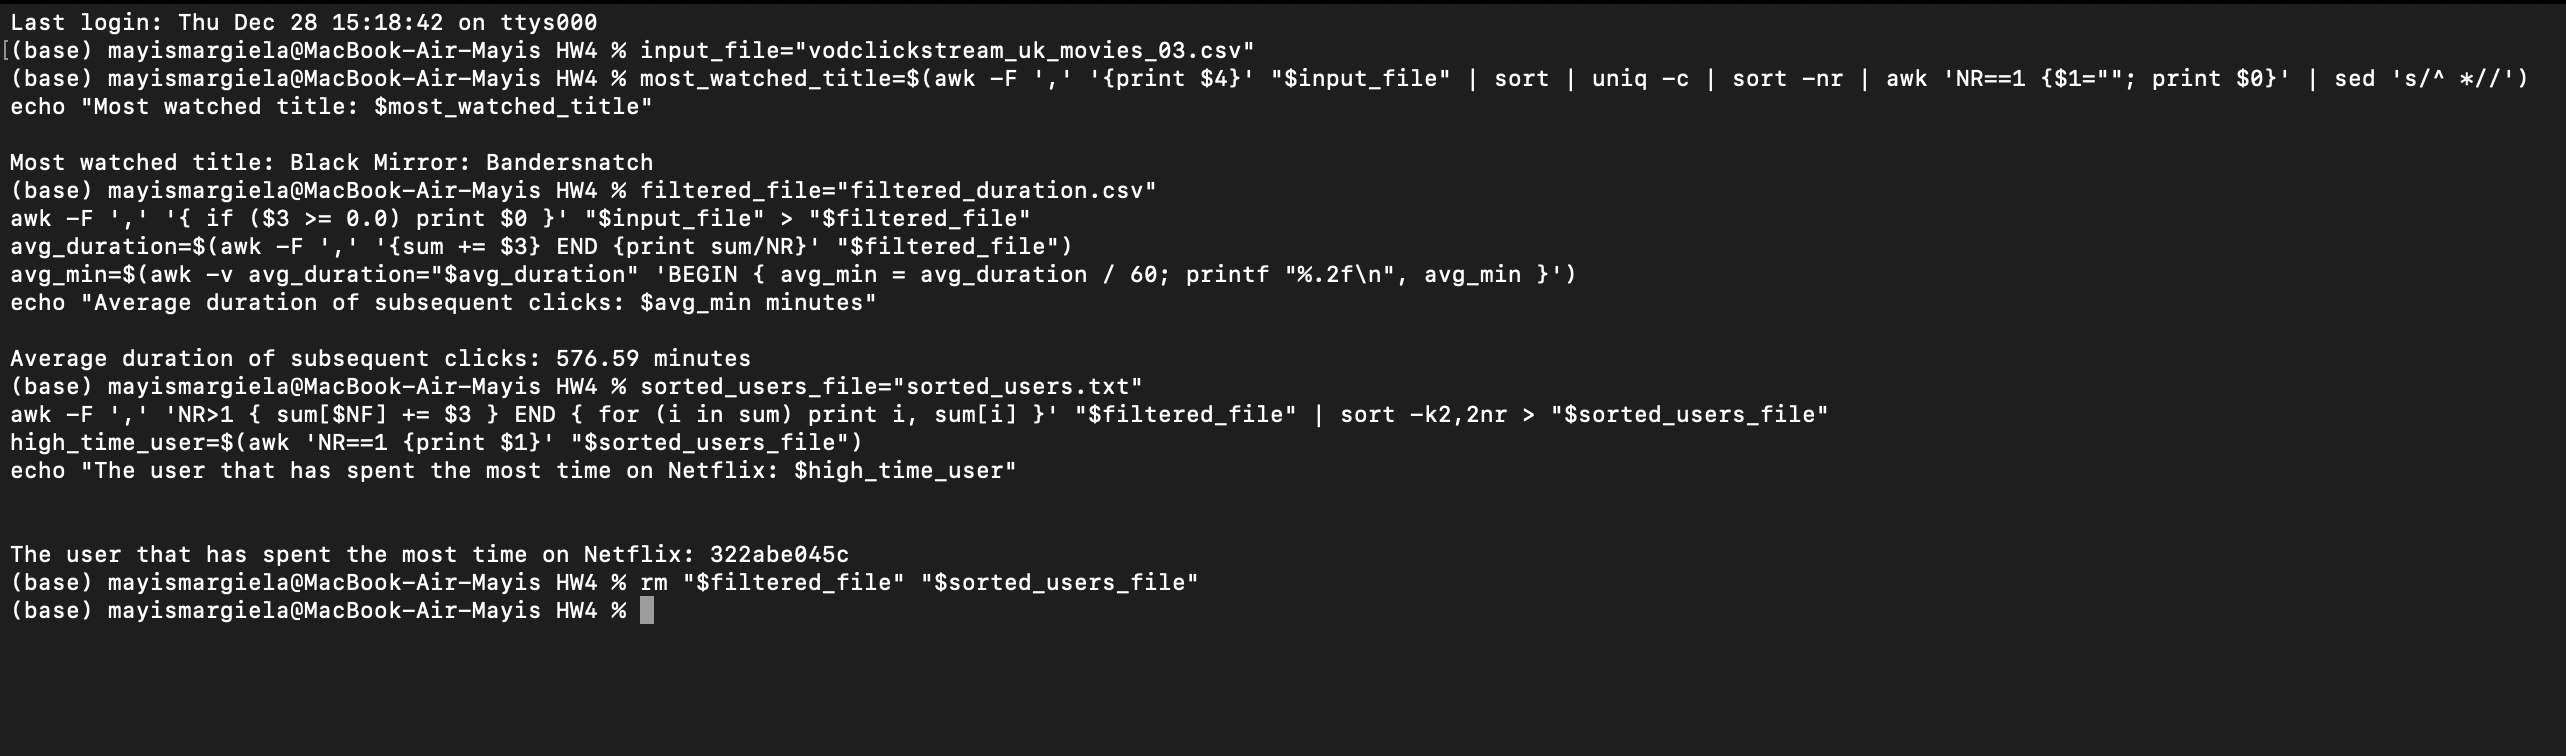

### 5 Algorithmic Question.

#### a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on because he wants to do paid counseling for other desperate students: in a recursive fashion, the helped helps the helpable.

In [ ]:
# Input
initial_score = int(input())
exam_marks = list(map(int, input().split()))


def highest_score(S, marks):
    # Base case: If there are no more exams, return the current score
    if not marks:
        return S
    
    # Try taking each exam and recursively calculate the highest score
    max_score = float('-inf')
    for p in marks:
        # For "easy" exams
        if p < S:
            new_score = highest_score(p, [x + S - p for x in marks if x != p])
        # For "hard" exams
        else:
            new_score = highest_score(p, [x - p + S for x in marks if x != p])
        
        # Update the maximum score
        max_score = max(max_score, new_score)
    
    return max_score

# Calculate and print the result
result = highest_score(initial_score, exam_marks)
print("The highest score Federico could get is:", result)


#### b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university!

The time complexity analysis for the `highest_score` function:

The `highest_score` function follows a recursive approach, exploring all possible combinations of exams. Let \$( S \$) be the initial score, and \$( N \)$ be the number of exams.

The function iterates over each exam mark, making recursive calls for both "easy" and "hard" scenarios. The branching factor of the recursion is 2, as there are two choices for each exam.

Let \$( T(S, N) \)$ denote the time complexity of the `highest_score` function. The recurrence relation for the time complexity can be expressed as:

\$
T(S, N) = 2 \cdot T(S - p + S, N-1) + 2 \cdot T(p, N-1)
\$

Here, \$( p \)$ represents the current exam mark.

The base case occurs when there are no more exams (\$( N = 0 \)$), and the time complexity is constant:

\$
T(S, 0) = O(1)
\$

In the worst case, the function explores all possible combinations, leading to a binary tree with a height of \$( N \$). Therefore, the overall time complexity can be expressed as:

\$
T(S, N) = O(2^N)
\$

This is an exponential time complexity, where the function's running time grows rapidly with the number of exams. The efficiency of this recursive algorithm can be significantly improved by applying memoization or dynamic programming techniques to avoid redundant computations. So Federico is right the algorithm is slow.

#### c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)

In [ ]:
# Input
initial_score = int(input())
exam_marks = list(map(int, input().split()))

def highest_score_memoized(S, marks, memo):
    # Base case: If there are no more exams, return the current score
    if not marks:
        return S

    # Check if the result is already memoized
    if (S, tuple(marks)) in memo:
        return memo[(S, tuple(marks))]

    # Try taking each exam and recursively calculate the highest score
    max_score = float('-inf')
    for p in marks:
        # For "easy" exams
        if p < S:
            new_score = highest_score_memoized(p, [x + S - p for x in marks if x != p], memo)
        # For "hard" exams
        else:
            new_score = highest_score_memoized(p, [x - p + S for x in marks if x != p], memo)

        # Update the maximum score
        max_score = max(max_score, new_score)

    # Memoize the result
    memo[(S, tuple(marks))] = max_score
    return max_score

# Initialize memoization dictionary
memo = {}

# Calculate and print the result
result = highest_score_memoized(initial_score, exam_marks, memo)
print("The highest score Federico could get is:", result)


Let's formally express the time complexity analysis for the memoized version of the `highest_score`:

The memoized algorithm aims to avoid redundant computations by storing and reusing previously calculated results. Let \$(T(S, N)\$) be the time complexity of the memoized algorithm, where \$(S\$) is the initial score and \$(N\$) is the number of exams.

The recurrence relation for the time complexity can be expressed as:

\$
T(S, N) = N \cdot O(1) + T(S-1, N-1) + T(S-2, N-1) + \ldots + T(1, N-1)
\$

Here, \$(N \cdot O(1)\$) represents the constant time spent in each iteration of the outer loop, and the subsequent terms represent the recursive calls for "easy" and "hard" scenarios.

The base case occurs when there are no more exams (\$(N = 0\))$, and the time complexity is constant:

\$
T(S, 0) = O(1)
\$

The memoization ensures that if a subproblem with the same parameters \$((S, N)\$) has been solved before, the result is retrieved from the memoization table in constant time.

In the worst case, the algorithm explores each unique combination of \$((S, N)\$) exactly once due to memoization. Therefore, the overall time complexity is:

\$
T(S, N) = O(N) \cdot O(1) = O(N)
\$

This represents a substantial improvement over the original recursive algorithm's exponential time complexity. The efficiency of the memoized algorithm is linear in the number of exams.

#### d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!

In [ ]:
def highest_score_optimized(S, marks):
    # Base case: If there are no more exams, return the current score
    if not marks:
        return S

    # Sort the exam marks in descending order
    marks.sort(reverse=True)

    # Try taking each exam and recursively calculate the highest score
    max_score = float('-inf')
    for p in marks:
        # For "easy" exams
        if p < S:
            new_score = highest_score_optimized(p, marks[1:]) + S - p
        # For "hard" exams
        else:
            new_score = highest_score_optimized(p, marks[1:]) + S - p

        # Update the maximum score
        max_score = max(max_score, new_score)

    return max_score

# Input
initial_score = int(input())
exam_marks = list(map(int, input().split()))

# Calculate and print the result
result = highest_score_optimized(initial_score, exam_marks)
print("The highest score Federico could get is:", result)

No matter how hard i tried the CharGPT botcouldn't give me correct optimized solution for this problem.